# Part One (On Hold): 
1. Upgrade imSim to use more sophisticated PSF models from Josh including optical components. [R] we should check with SSim to see if they are already planning this on some reasonable timescale, so we can piggyback off their planned effort.
2. Generate multiple realisations of star fields and run them through the DM stack [PSFEx](psfex.readthedocs.io/en/latest/).
3. Find the mean PSF error from these realisations.  Pass this on to part two.
4. (Stretch goal) Explore alternative PSF measurement strategies from [Piff](rmjarvis.github.io/Piff/html/index.html) to see if they reduce this

# Part Two:

#### Section 1

1. (Temporary) Rescale HSC mean residual shears/PSF values to LSST scales to generate a residual template. [R] I think it might also be instructive to take some simple toy models, e.g., purely radial PSF anisotropy patterns, purely horizontal (in focal plane coordinates), etc.  These are way oversimplified but might give some insight on the importance of various aspects of the dither patterns.  For example, a purely horizontal pattern in focal plane coordinates will not average down at all unless you have a rotational dither sequence.


In [1]:
%pylab inline
from angles import r2d, r2arcs, d2arcs
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr, healpy as hp
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 18,12
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [34]:
sns.set_context('talk')

# Create some simplified models

e.g. completely diverging field or completely horizontal field:

In [85]:
def radial_delta_PSF():
    from angles import r2d, r2arcs, d2arcs
    X = np.random.rand(int(500))*2.4 - 1.2
    Y = np.random.rand(int(500))*2.4 - 1.2
    r = np.sqrt(X**2+Y**2)
    theta = np.arctan(Y/X)
    e1 = r*np.cos(2*theta)
    e2 = r*np.sin(2*theta)
    return X,Y,e1,e2
def horizontal_delta_PSF():
    from angles import r2d, r2arcs, d2arcs
    X = np.random.randn(int(1E3))
    Y = np.random.randn(int(1E3))
    e1 = np.ones(1000)*0.1
    e2 = np.zeros(len(X))
    return X,Y,e1,e2

plotting it:

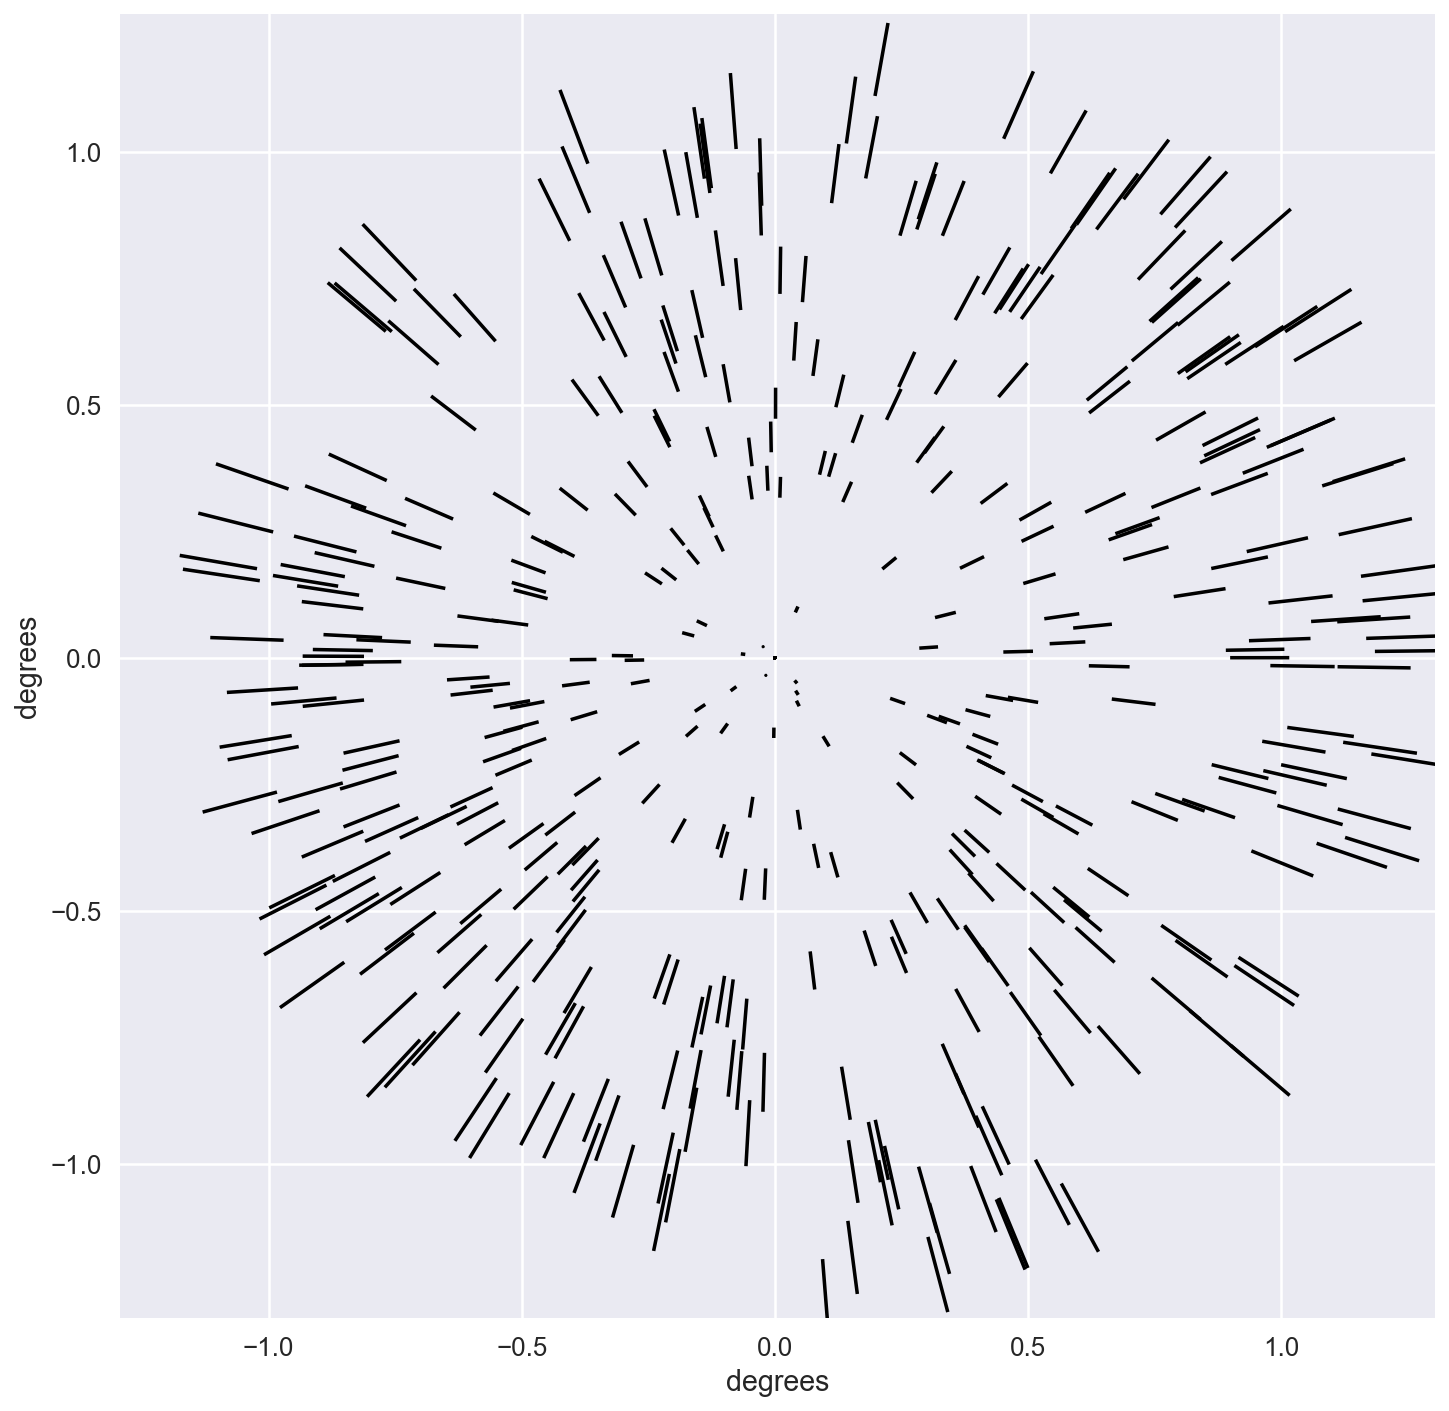

In [110]:
X,Y,e1,e2 = radial_delta_PSF()
for i in range(len(X)):
    if np.sqrt(X[i]**2 + Y[i]**2)>1.2:
        X[i],Y[i],e1[i],e2[i] = 0,0,0,0
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(e1)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
std2fwhm = 2.*np.sqrt(2.*np.log(2.))
V = np.zeros(np.shape(U))
pixel_scale = d2arcs(1)
Q = plt.quiver(X,Y,U,V,angles=angles,headlength=0,
               headaxislength=0,scale=20,cmap='viridis')
#qk = plt.quiverkey(Q, 0.8, 0.85, 0.05, r'$|e|=0.05$', labelpos='E', coordinates='figure')
plt.xlabel('degrees')
plt.ylabel('degrees')
plt.axes().set_aspect('equal')
plt.savefig('radial.png')

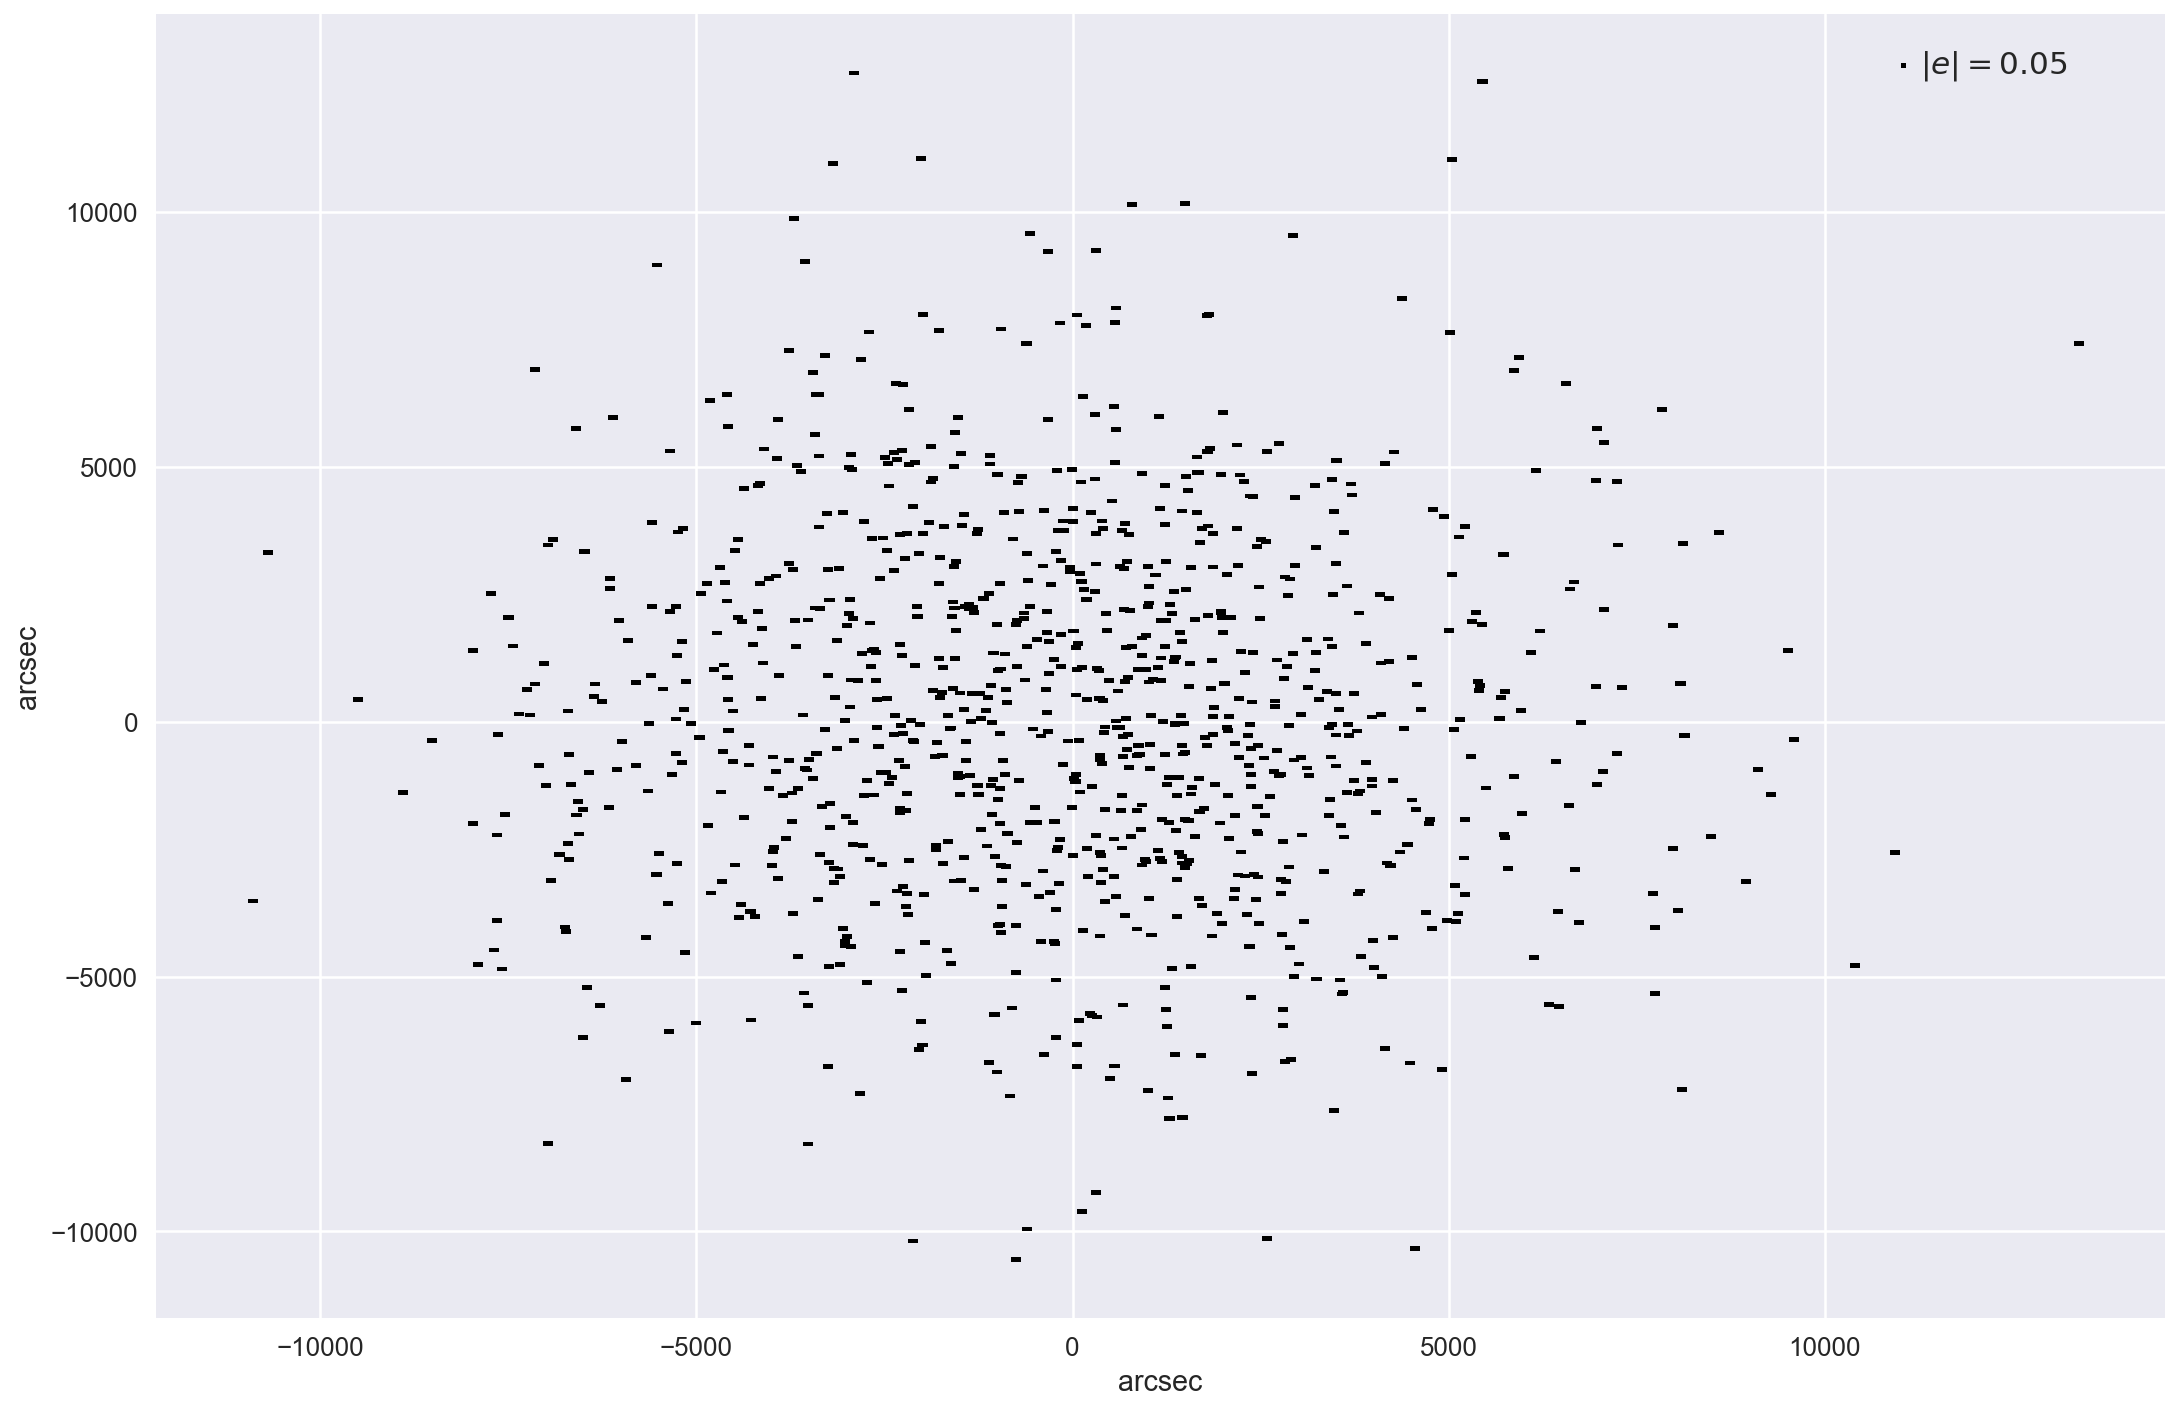

In [72]:
X,Y,e1,e2 = horizontal_delta_PSF()
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(e1)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
std2fwhm = 2.*np.sqrt(2.*np.log(2.))
V = np.zeros(np.shape(U))
pixel_scale = d2arcs(1)
Q = plt.quiver(pixel_scale*X,pixel_scale*Y,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=20,cmap='viridis')
qk = plt.quiverkey(Q, 0.8, 0.85, 0.05, r'$|e|=0.05$', labelpos='E', coordinates='figure')
plt.xlabel('arcsec')
plt.ylabel('arcsec')

We're not gonna simulate galaxies; rather we will use standard values for $T_{gal}$

 ~~First, get $\xi_+$ 
 (the following is a placeholder psf correlation -- want galaxy shear correlation for actual analysis~~ 

In [6]:
cat = tr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='degrees',dec_units='degrees')
gg = tr.GGCorrelation(min_sep=1, max_sep=200, nbins=40, sep_units='arcmin')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
r = np.exp(gg.meanlogr)

Plot it:

/usr/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


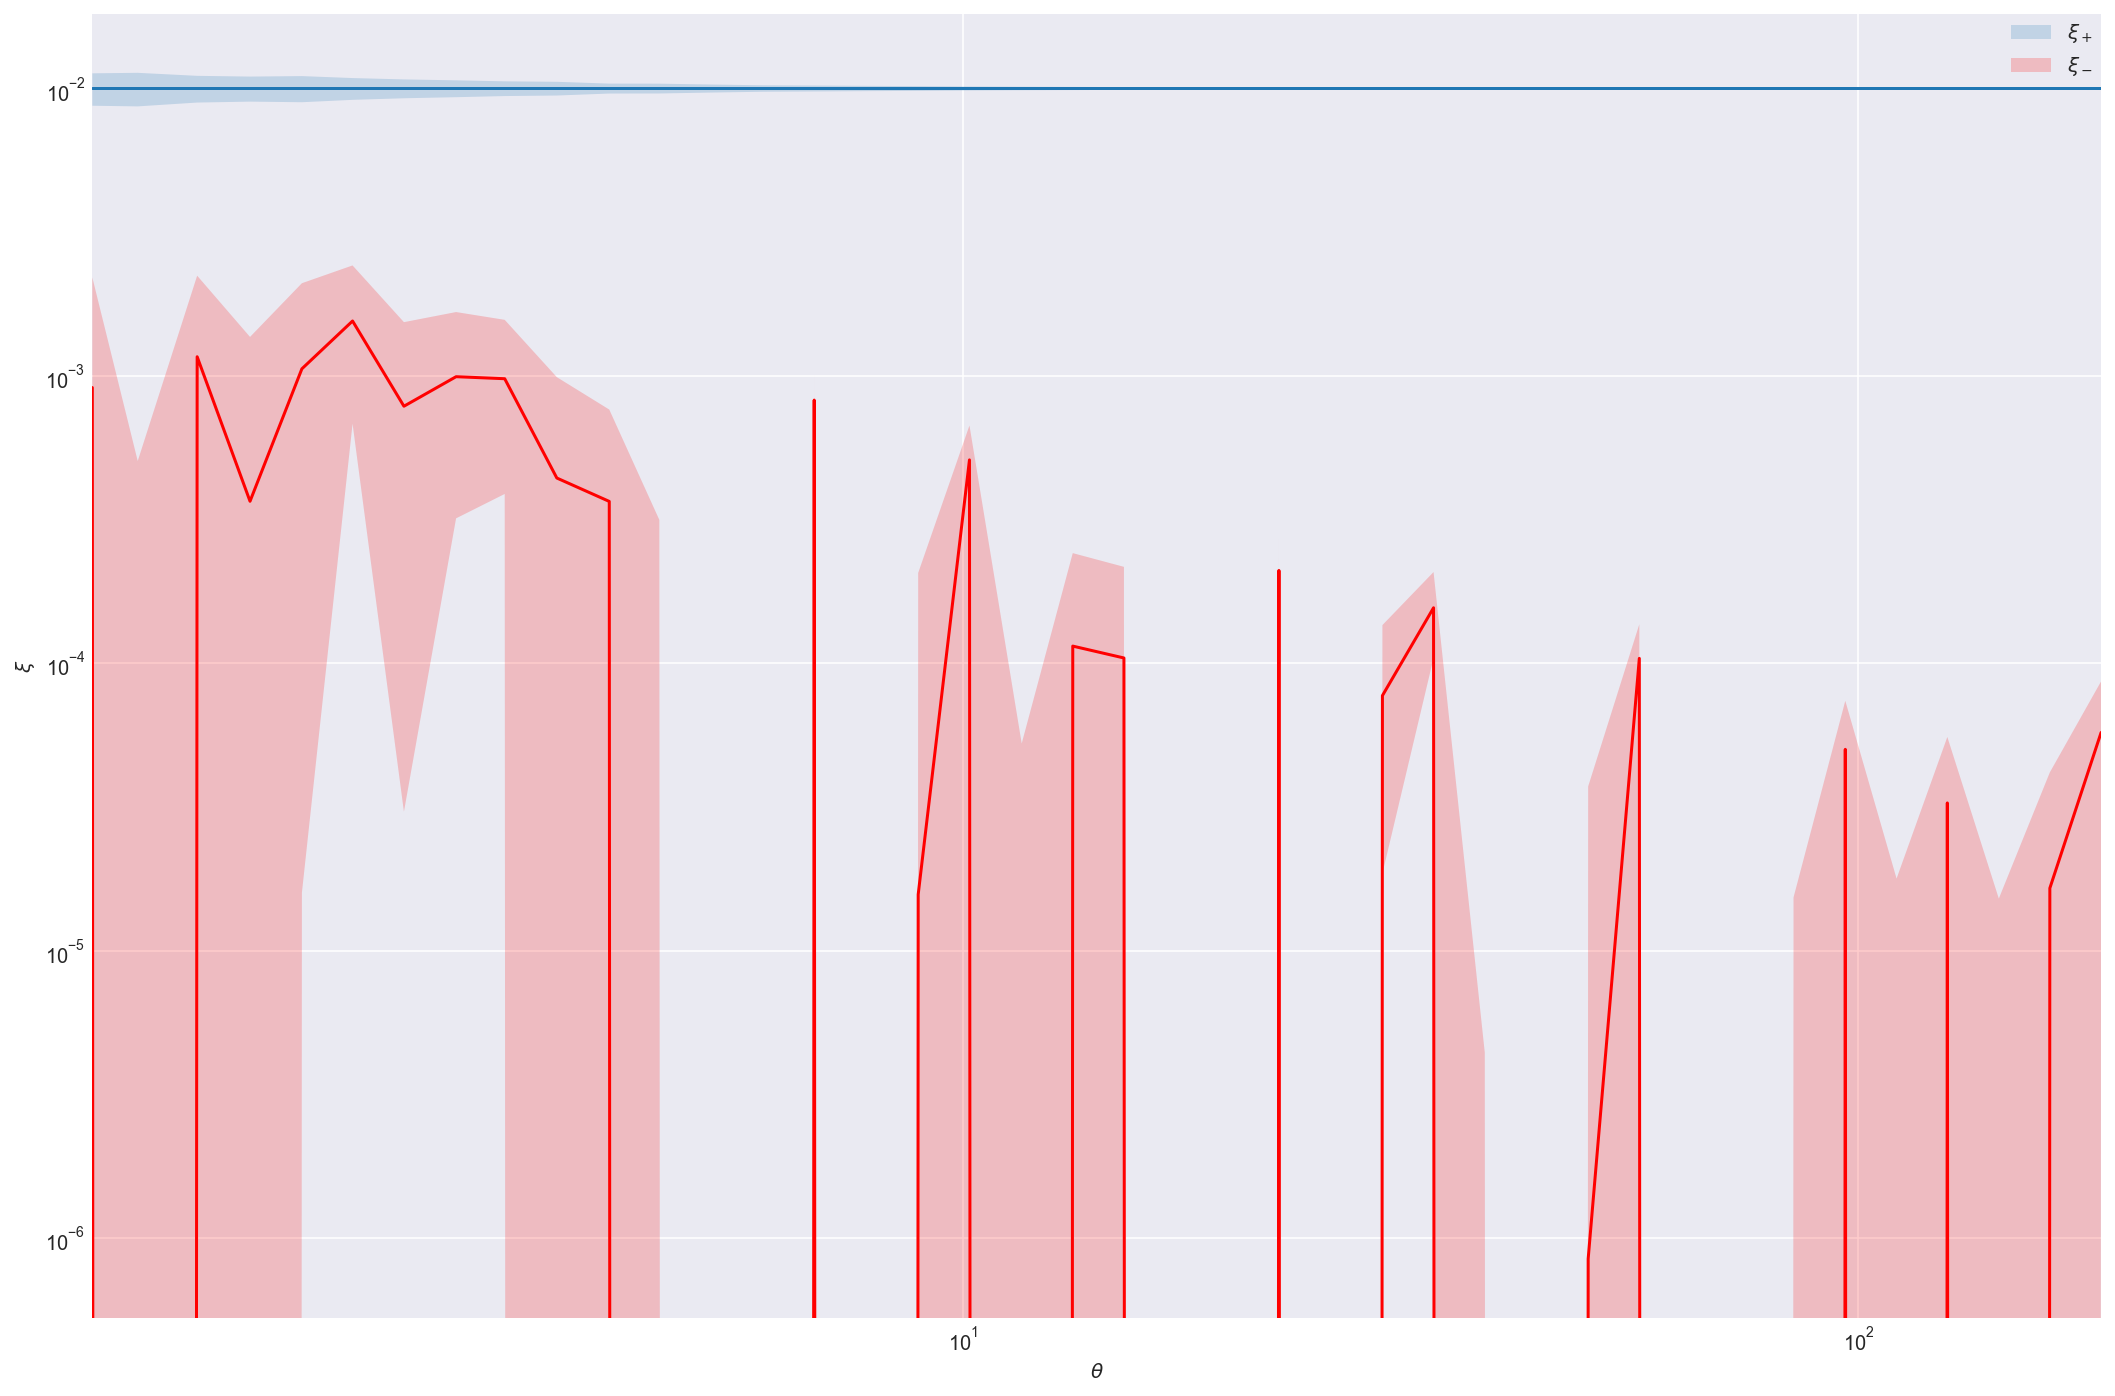

In [7]:
def sns_time_series(x_tuple,y_tuple,xip,xim,errors=0,two=False, *args,**kwargs):
    """seaborn time series, with error-bands"""
    if (type(x_tuple)==tuple)|(type(y_tuple)==tuple):
        pass
    else:
        raise TypeError()
    import seaborn.timeseries
    x, x_label = x_tuple
    y, y_label = y_tuple
    if two==True:
        x2,x_label2 = x_tuple2
        y2,y_label2 = y_tuple2
    def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
        std = errors
        ci = np.asarray((central_data - std, central_data + std))
        kwargs.update({"central_data": central_data, "ci": ci, "data": data})
        seaborn.timeseries._plot_ci_band(*args, **kwargs)
    seaborn.timeseries._plot_std_bars = _plot_std_bars

    sns.tsplot(xip,r,err_style='std_bars')
    sns.tsplot(xim,r,err_style='std_bars',color='r')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(1, 1), 
               loc='upper right', borderaxespad=0.)
sns_time_series((X,r'$\theta$'),(Y,r'$\xi$'),xip,xim,errors=sigma)

#### Section 2
$2.$ Explore how  these average down and the impact on final shear measurements (and spectra?) [R] I think this has two parts: (a) see how the rho statistics and PSF model fractional size residual averages $(\sigma_2 - \sigma_1)/<\sigma>$ down with time, and (b) put together the framework for how that propagates into shear statistics (presumably the same Gaussian formalism everyone else uses to estimate this without actually simulating loads of galaxy images). [from the paper](https://arxiv.org/pdf/1507.05603.pdf)


## The modelling error is:
$$\delta e_{sys} = (e-e_{PSF}) \left( \frac{T_{PSF}}{T_{gal}} \right) \frac{\delta T_{PSF}}{T_{PSF}} - \left( \frac{T_{PSF}}{T_{gal}} \right)\delta e_{PSF}$$


## Propagate into shear errors:
$\rho$ statistics:

$$\rho_1 = \left\langle \delta e_{PSF}^*(x) \; \delta e_{PSF} (x+\theta) \right\rangle$$

$$\rho_2 = \left\langle e_{PSF}^* (x) \; \delta e_{PSF} (x+\theta) \right\rangle $$
$$\rho_3 = \left\langle \left( e_{PSF}^*   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x) \; \left(e_{PSF}   \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_4 = \left\langle \delta e_{PSF}^* (x)\;\left( e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta)\right\rangle $$
$$\rho_5 = \left\langle e_{PSF}^* (x)\; \left(e_{PSF} \frac{\delta T_{PSF}}{T_{PSF}}\right)(x+\theta) \right\rangle $$

Then

$$\delta \xi_+ (\theta) = 2 \left\langle \frac{T_{PSF}}{T_{gal}} \frac{\delta T_{PSF}}{T_{PSF}} \right\rangle \xi_+(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_1(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_2(\theta) 
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_3(\theta)
 + \left\langle \frac{T_{PSF}}{T_{gal}} \right\rangle^2 \rho_4(\theta)
 - \alpha\left\langle\frac{T_{PSF}}{T_{gal}}\right\rangle \rho_5(\theta) 
$$

### Notes about $\alpha$
$\alpha$ is the PSF leakage multiplicative error. For now, we don't have it, assume (wrongly) $\alpha= 0$, which makes 2 terms from the equation above 0. The code, however, is ready to calculate those 2 terms when we have an $\alpha$

#### Section 3
$3.$ Explore how changing the survey strategy affects how this averaging down varies with time

From our model, we get $$\Delta e_1 = \epsilon e_1^{PSF} = e_1^{*}-e_1^{PSF},$$ 

$$\Delta e_2 = \epsilon e_2^{PSF} = e_2^{*}-e_2^{PSF},$$

$$\sigma^{*}, \sigma^{PSF},$$ and

$$ e_{+}^{*}, e_{\times}^{*} $$

but $$ \begin{bmatrix} e_1 \\ 
e_2
\end{bmatrix} =  \begin{bmatrix}
cos 2\theta & -sin 2\theta \\
sin 2\theta & cos 2\theta 
\end{bmatrix} \begin{bmatrix} e_{+} \\ 
e_{\times} 
\end{bmatrix}$$
from which we get $e_1^{*}$ and $e_2^{*}$


then $ e_i^{PSF} = e_i^{*}/(1+\epsilon) $ where $i=1,2$ and $\epsilon$ is a small number compared to 1.

by definition: $$ e_1^{k} = \frac{M_{xx}^k - M_{yy}^k}{TrM^k} $$ and $$ e_2^k = \frac{2M_{xy}^k }{TrM^k} $$
where $k$ is either PSF or *; and $TrM = M_{xx} + M_{yy}$
solving for $M_{ij}$ we get:

$$M^{k} = \frac{TrM^k}{2} \begin{bmatrix}
     e_1 + 1       &  e_2  \\
     e_2       &  - e_1 + 1
\end{bmatrix}$$

then after taking the arithmetic mean of each of $M_{ij}$ to get $\langle M \rangle$, we can go back to e-space:

$$ e_1^{k} = \frac{M_{xx}^k - M_{yy}^k}{TrM^k} $$ and $$ e_2^k = \frac{2M_{xy}^k }{TrM^k} $$ and $$\sigma = \sqrt{TrM^k/2} $$

## Dithering

In [12]:
def plotDither(ditherStacker, nvisits=1000, addPolygon=True):
    # Set up some 'data' on a single pointing to dither
    fieldIds = np.ones(nvisits, int)
    fieldRA = np.zeros(nvisits, float) + np.radians(10.0)
    fieldDec = np.zeros(nvisits, float) 
    night = np.arange(0, nvisits/2.0, 0.5)
    night = np.floor(night) 
    simdata = np.core.records.fromarrays([fieldIds, fieldRA, fieldDec, night], 
                                         names = ['fieldID', 'fieldRA', 'fieldDec', 'night'])
    # Apply the stacker. 
    simdata = ditherStacker.run(simdata)
    
    fig = plt.figure()
    plt.axis('equal')
    # Draw a point for the center of the FOV.
    x = np.degrees(simdata['fieldRA'][0])
    y = np.degrees(simdata['fieldDec'][0])
    plt.plot(x, y, 'g+')
    # Draw a circle approximately the size of the FOV.
    stepsize = np.pi/50.
    theta = np.arange(0, np.pi*2.+stepsize, stepsize)
    radius = 1.75
    plt.plot(radius*np.cos(theta)+x, radius*np.sin(theta)+y, 'g-')
    # Add the inscribed hexagon
    nside = 6
    a = np.arange(0, nside)
    xCoords = np.sin(2*np.pi/float(nside)*a + np.pi/2.0)*radius + x
    yCoords = np.cos(2*np.pi/float(nside)*a + np.pi/2.0)*radius + y
    xCoords = np.concatenate([xCoords, np.array([xCoords[0]])])
    yCoords = np.concatenate([yCoords, np.array([yCoords[0]])])
    plt.plot(xCoords, yCoords, 'b-')
    # Draw the dithered pointings.
    x = np.degrees(simdata[s.colsAdded[0]])
    y = np.degrees(simdata[s.colsAdded[1]])
    plt.plot(x, y, 'k-', alpha=0.2)
    plt.plot(x, y, 'r.')
    plt.title(s.__class__.__name__)

In [16]:
nvisits=1000; addPolygon=True
fieldIds = np.ones(nvisits, int)
fieldRA = np.zeros(nvisits, float) + np.radians(10.0)
fieldDec = np.zeros(nvisits, float) 
night = np.arange(0, nvisits/2.0, 0.5)
night = np.floor(night) 
simdata = np.core.records.fromarrays([fieldIds, fieldRA, fieldDec, night], 
                                     names = ['fieldID', 'fieldRA', 'fieldDec', 'night'])

ditherStacker = stackers.RandomDitherFieldPerVisitStacker(maxDither=1.75, inHex=False)
simdata = ditherStacker.run(simdata)

x = np.degrees(simdata[s.colsAdded[0]])
y = np.degrees(simdata[s.colsAdded[1]])
# for i in range(len(x)):
#     print x[i],y[i]# plt.plot(x, y, 'k-', alpha=0.2)
a = np.histogram2d(x,y)
a

(array([[  0.,   0.,   5.,   9.,   8.,   9.,  11.,   4.,   0.,   0.],
        [  0.,   6.,  19.,  16.,  14.,  11.,  12.,  15.,  12.,   0.],
        [  6.,   8.,  16.,  11.,  14.,   8.,  18.,  11.,   9.,  10.],
        [  9.,   9.,  10.,  16.,  14.,  11.,  12.,  16.,  13.,   9.],
        [ 10.,  16.,  12.,  15.,  10.,  11.,  17.,   9.,  23.,   8.],
        [ 12.,  11.,  10.,  11.,   8.,   7.,  14.,  12.,   6.,  19.],
        [  9.,  13.,  12.,  15.,  10.,  14.,  10.,   9.,   9.,   9.],
        [  6.,  13.,  14.,  16.,  13.,  13.,   9.,  12.,  13.,   5.],
        [  0.,  16.,  16.,  12.,  13.,  13.,  13.,  10.,  10.,   0.],
        [  0.,   0.,   8.,   8.,  10.,  12.,  11.,   2.,   0.,   0.]]),
 array([  8.25979365,   8.60400285,   8.94821205,   9.29242125,
          9.63663045,   9.98083965,  10.32504885,  10.66925804,
         11.01346724,  11.35767644,  11.70188564]),
 array([-1.73472647, -1.38929418, -1.0438619 , -0.69842961, -0.35299733,
        -0.00756504,  0.33786724,  0.68329953

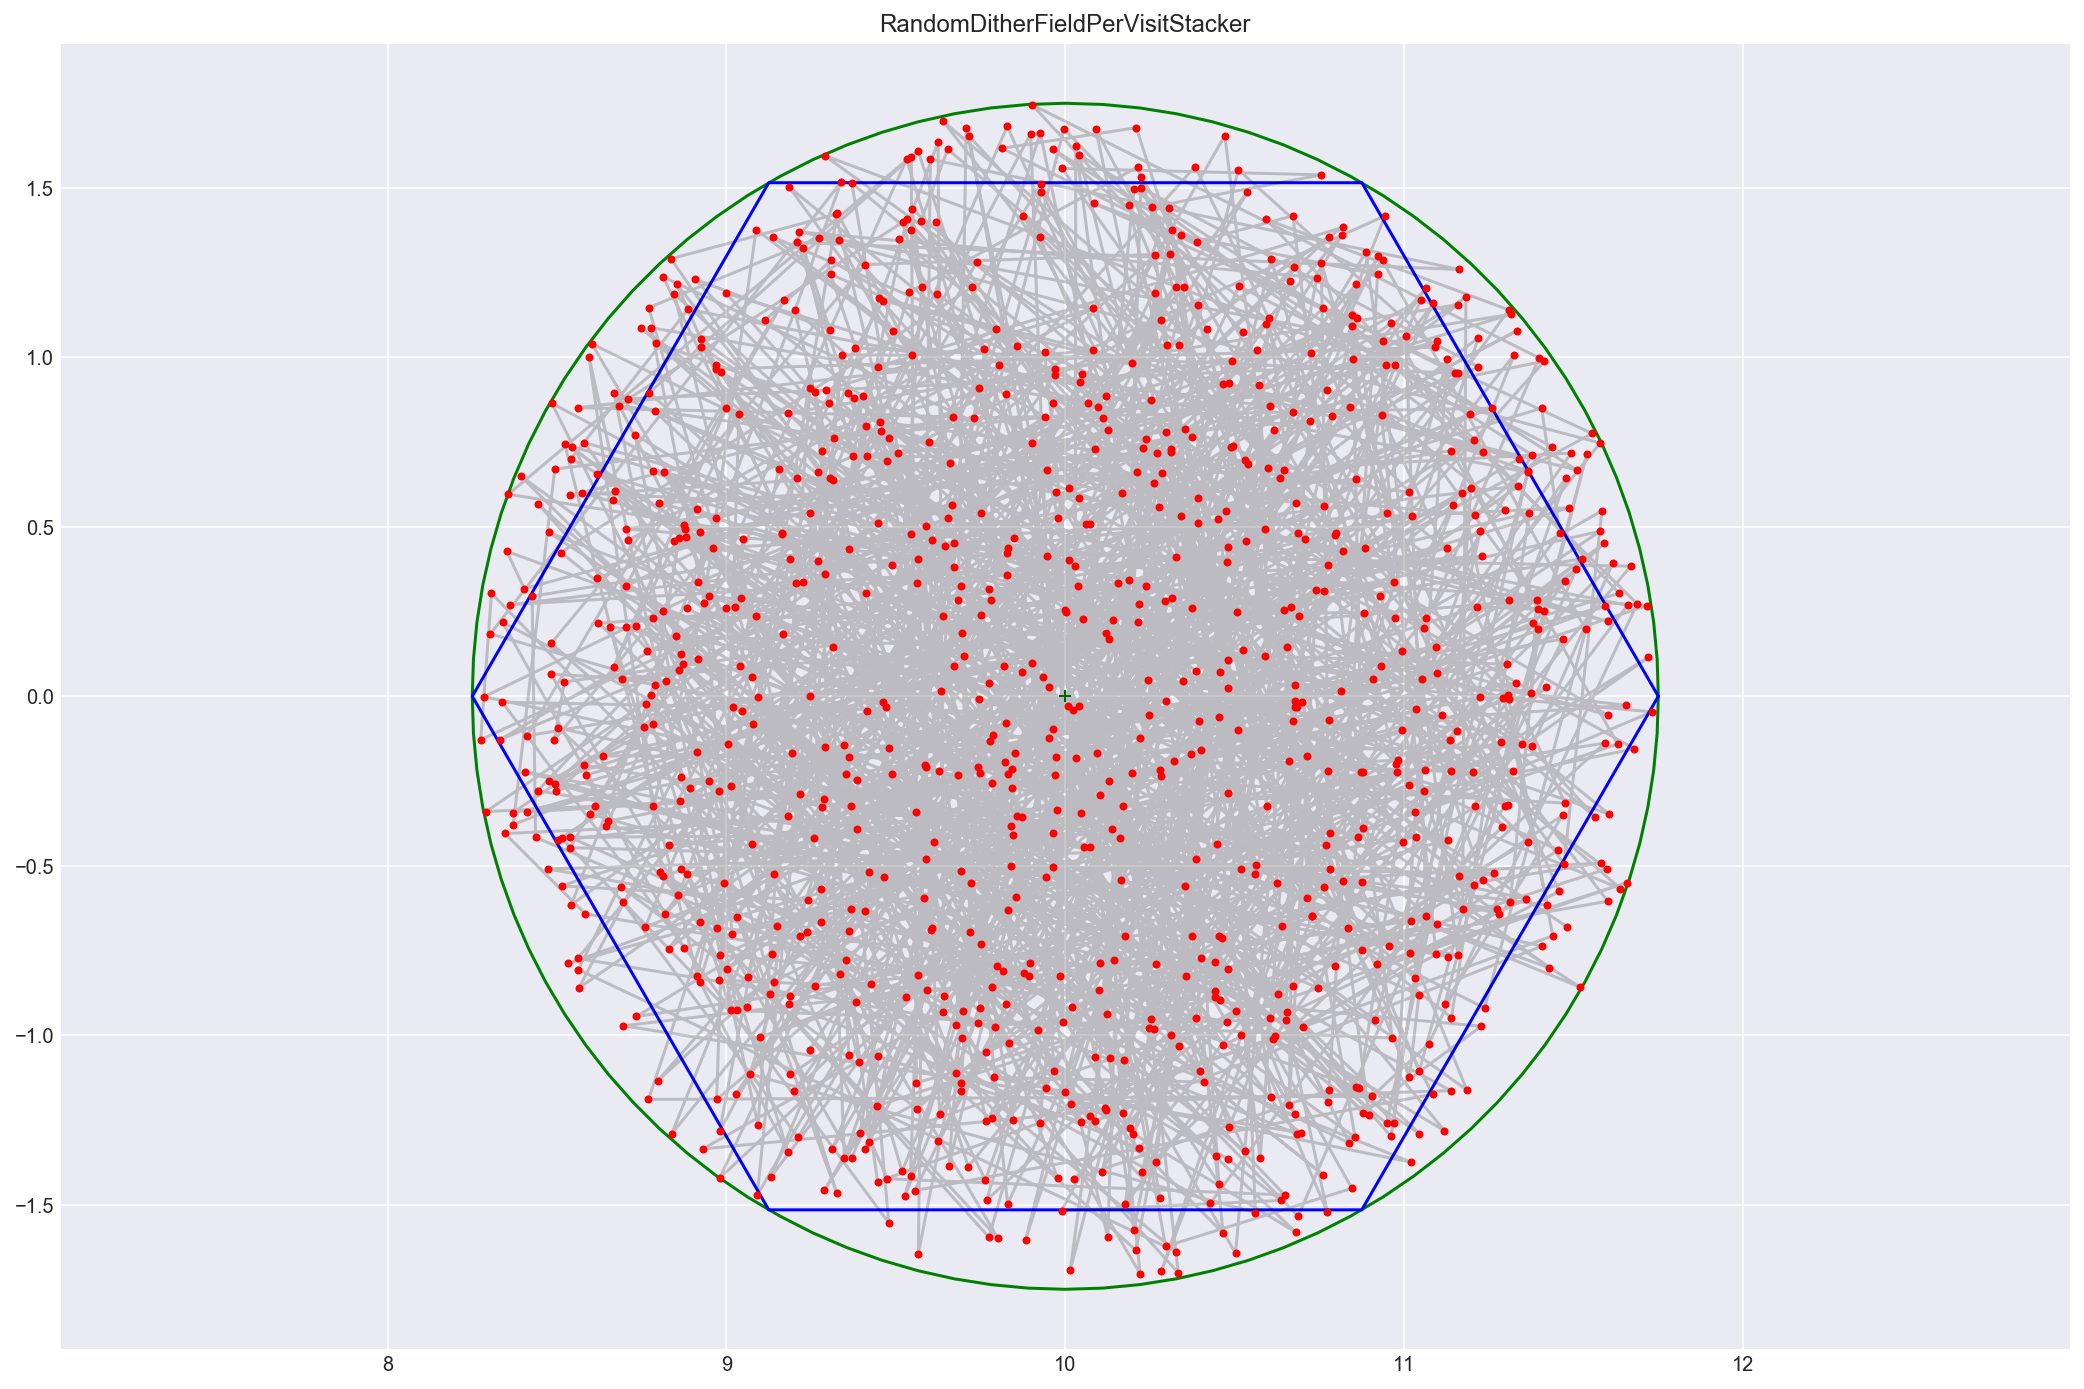

In [15]:
s = stackers.RandomDitherFieldPerVisitStacker(maxDither=1.75, inHex=False)
plotDither(s)

In [17]:
nside=512
metric = metrics.CountMetric('expMJD')
slicer = slicers.HealpixSlicer(nside=nside, latCol='ditheredDec', lonCol='ditheredRA')
slicer2 = slicers.HealpixSlicer(nside=nside, useCamera=True, radius=1.9, latCol='ditheredDec', lonCol='ditheredRA')
sqlWhere = 'filter = "r" and night < 400 and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (np.radians(50), np.radians(-50))
summaryMetrics = [metrics.SumMetric()]
bundle1 = metricBundles.MetricBundle(metric,slicer,sqlWhere, summaryMetrics=summaryMetrics)
bundle2 = metricBundles.MetricBundle(metric,slicer2,sqlWhere, summaryMetrics=summaryMetrics)
database = '/Users/myhome/Downloads/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(database)

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [12]:
del slicer, slicer2, bundle1,bundle2

outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)
bg = metricBundles.MetricBundleGroup({'NoCamera':bundle1}, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes
Querying database with constraint filter = "r" and night < 400 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Found 290 visits
Running:  ['NoCamera']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


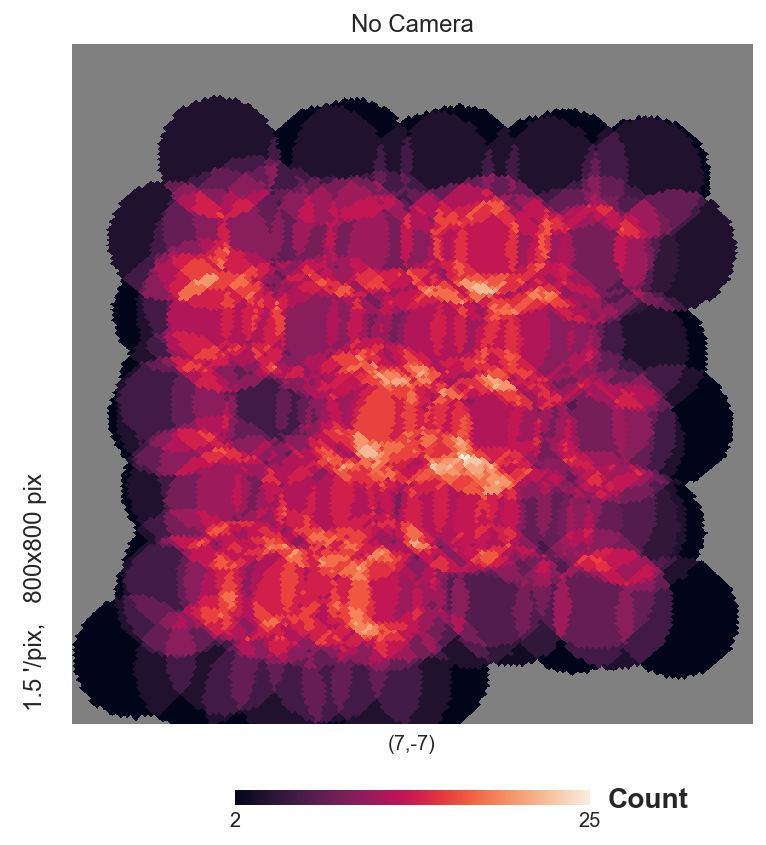

In [13]:
hp.gnomview(bundle1.metricValues,xsize=800,ysize=800, rot=(7,-7,0),  title='No Camera', unit='Count')

In [37]:

database = '/Users/myhome/Downloads/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(database)

sqlWhere = 'filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50))

pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)

In [38]:
pos = np.array(pos)

In [39]:
if any(row[1] == x for row in pos):
    pos2 = zip(*pos)[1]
if any(row[2] == x for row in pos):
    pos3 = zip(*pos)[2]

In [40]:
pos2,pos3 = np.array(map(lambda x: np.array(x)*180/np.pi,(pos2,pos3)))

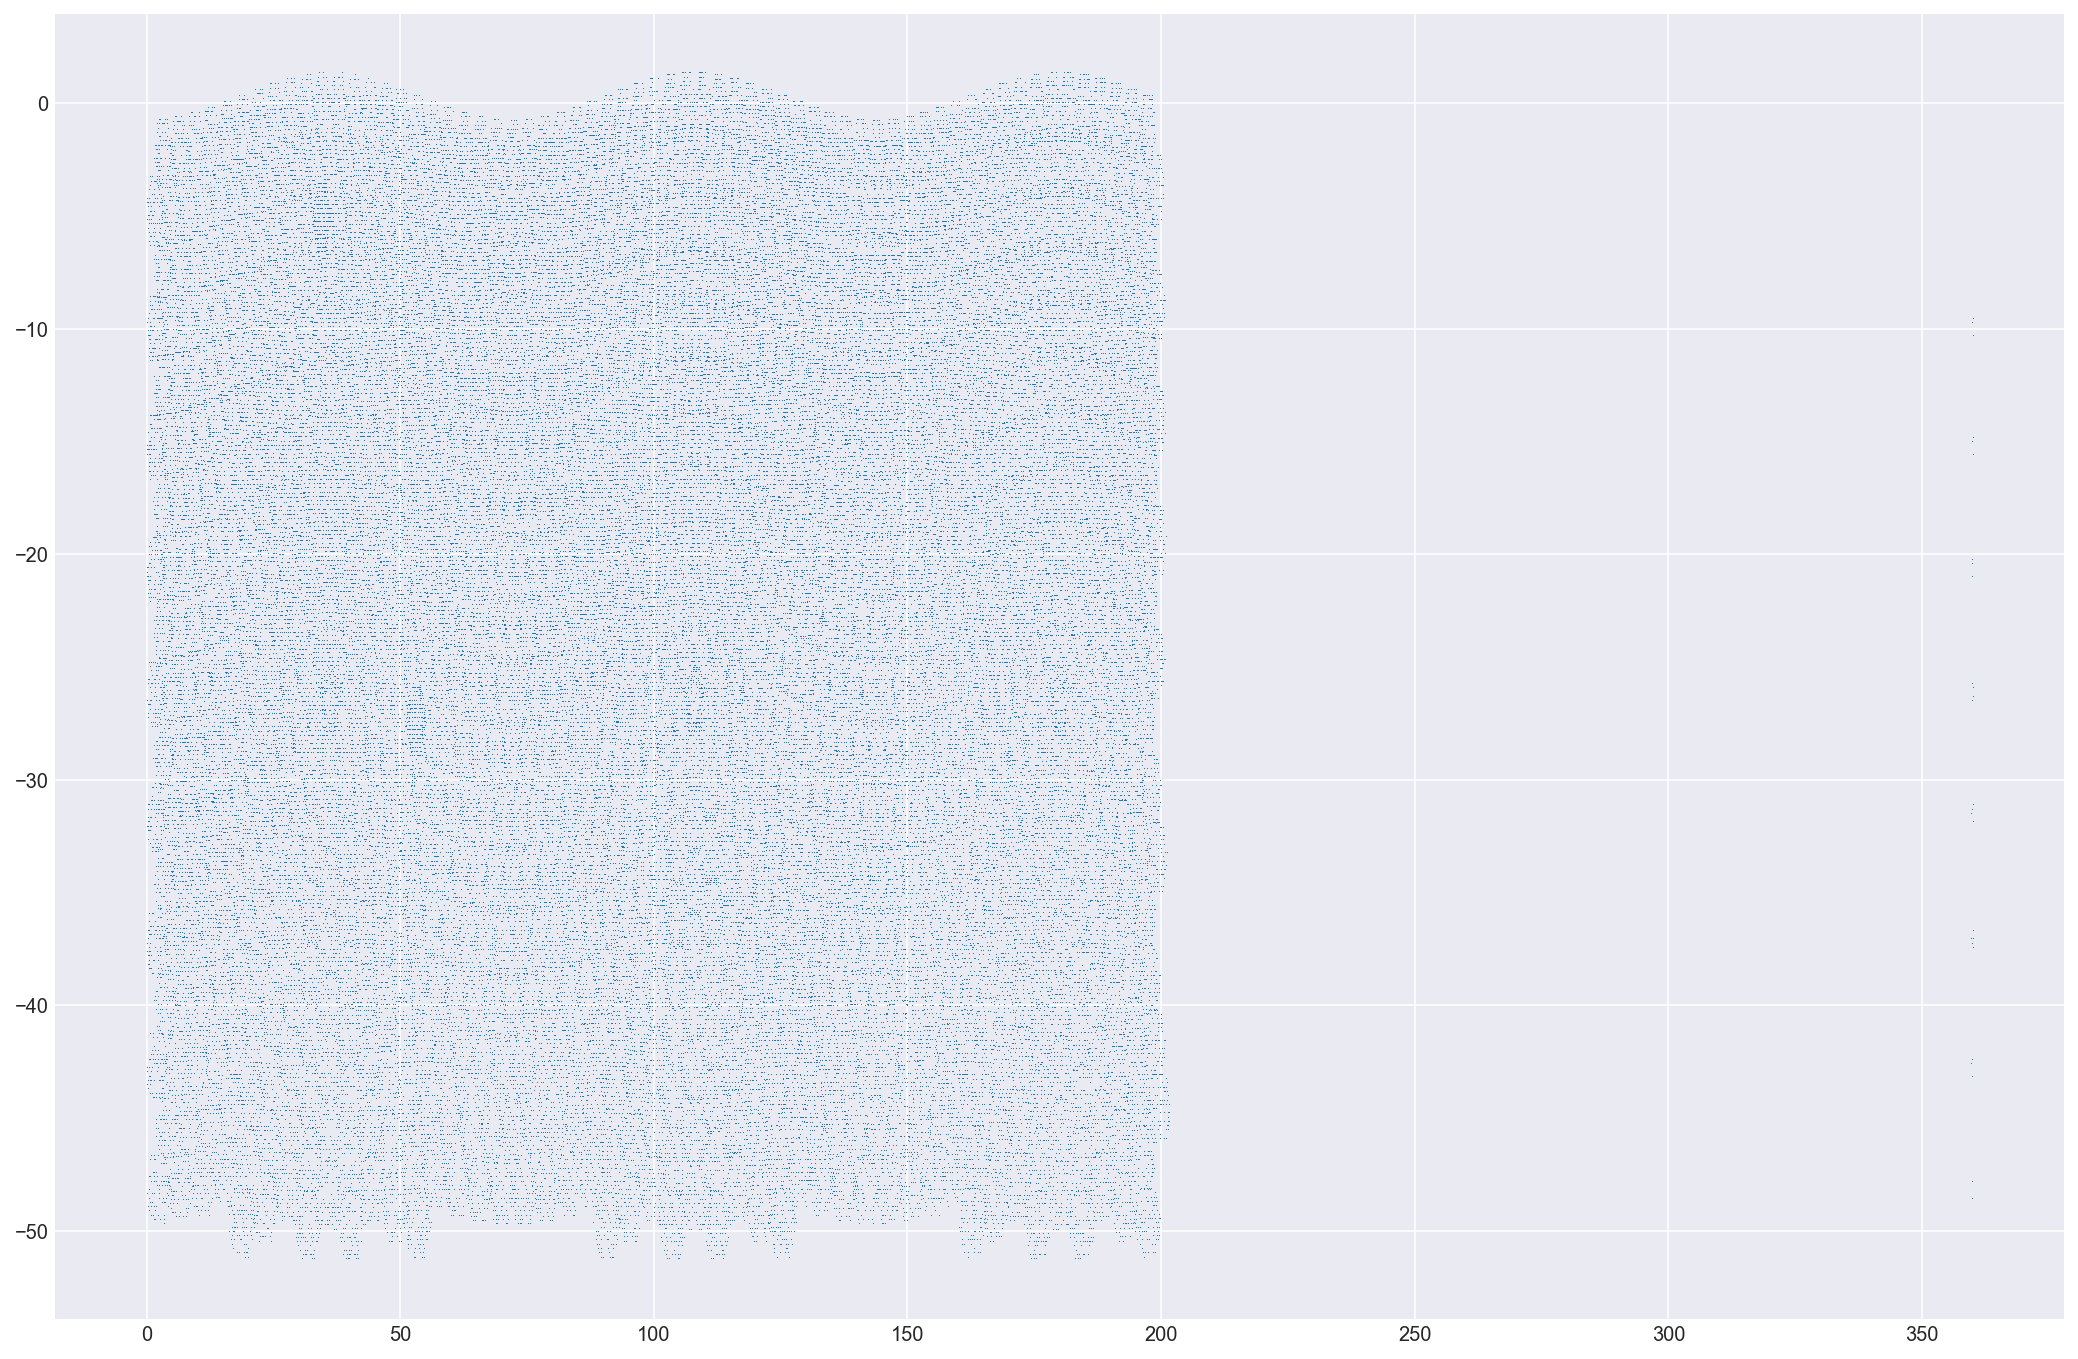

In [277]:
plt.plot(pos2,pos3,',')

In [41]:
pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=None)
pos = np.array(pos)


In [42]:
if any(row[1] == x for row in pos):
    pos2 = zip(*pos)[1]
if any(row[2] == x for row in pos):
    pos3 = zip(*pos)[2]


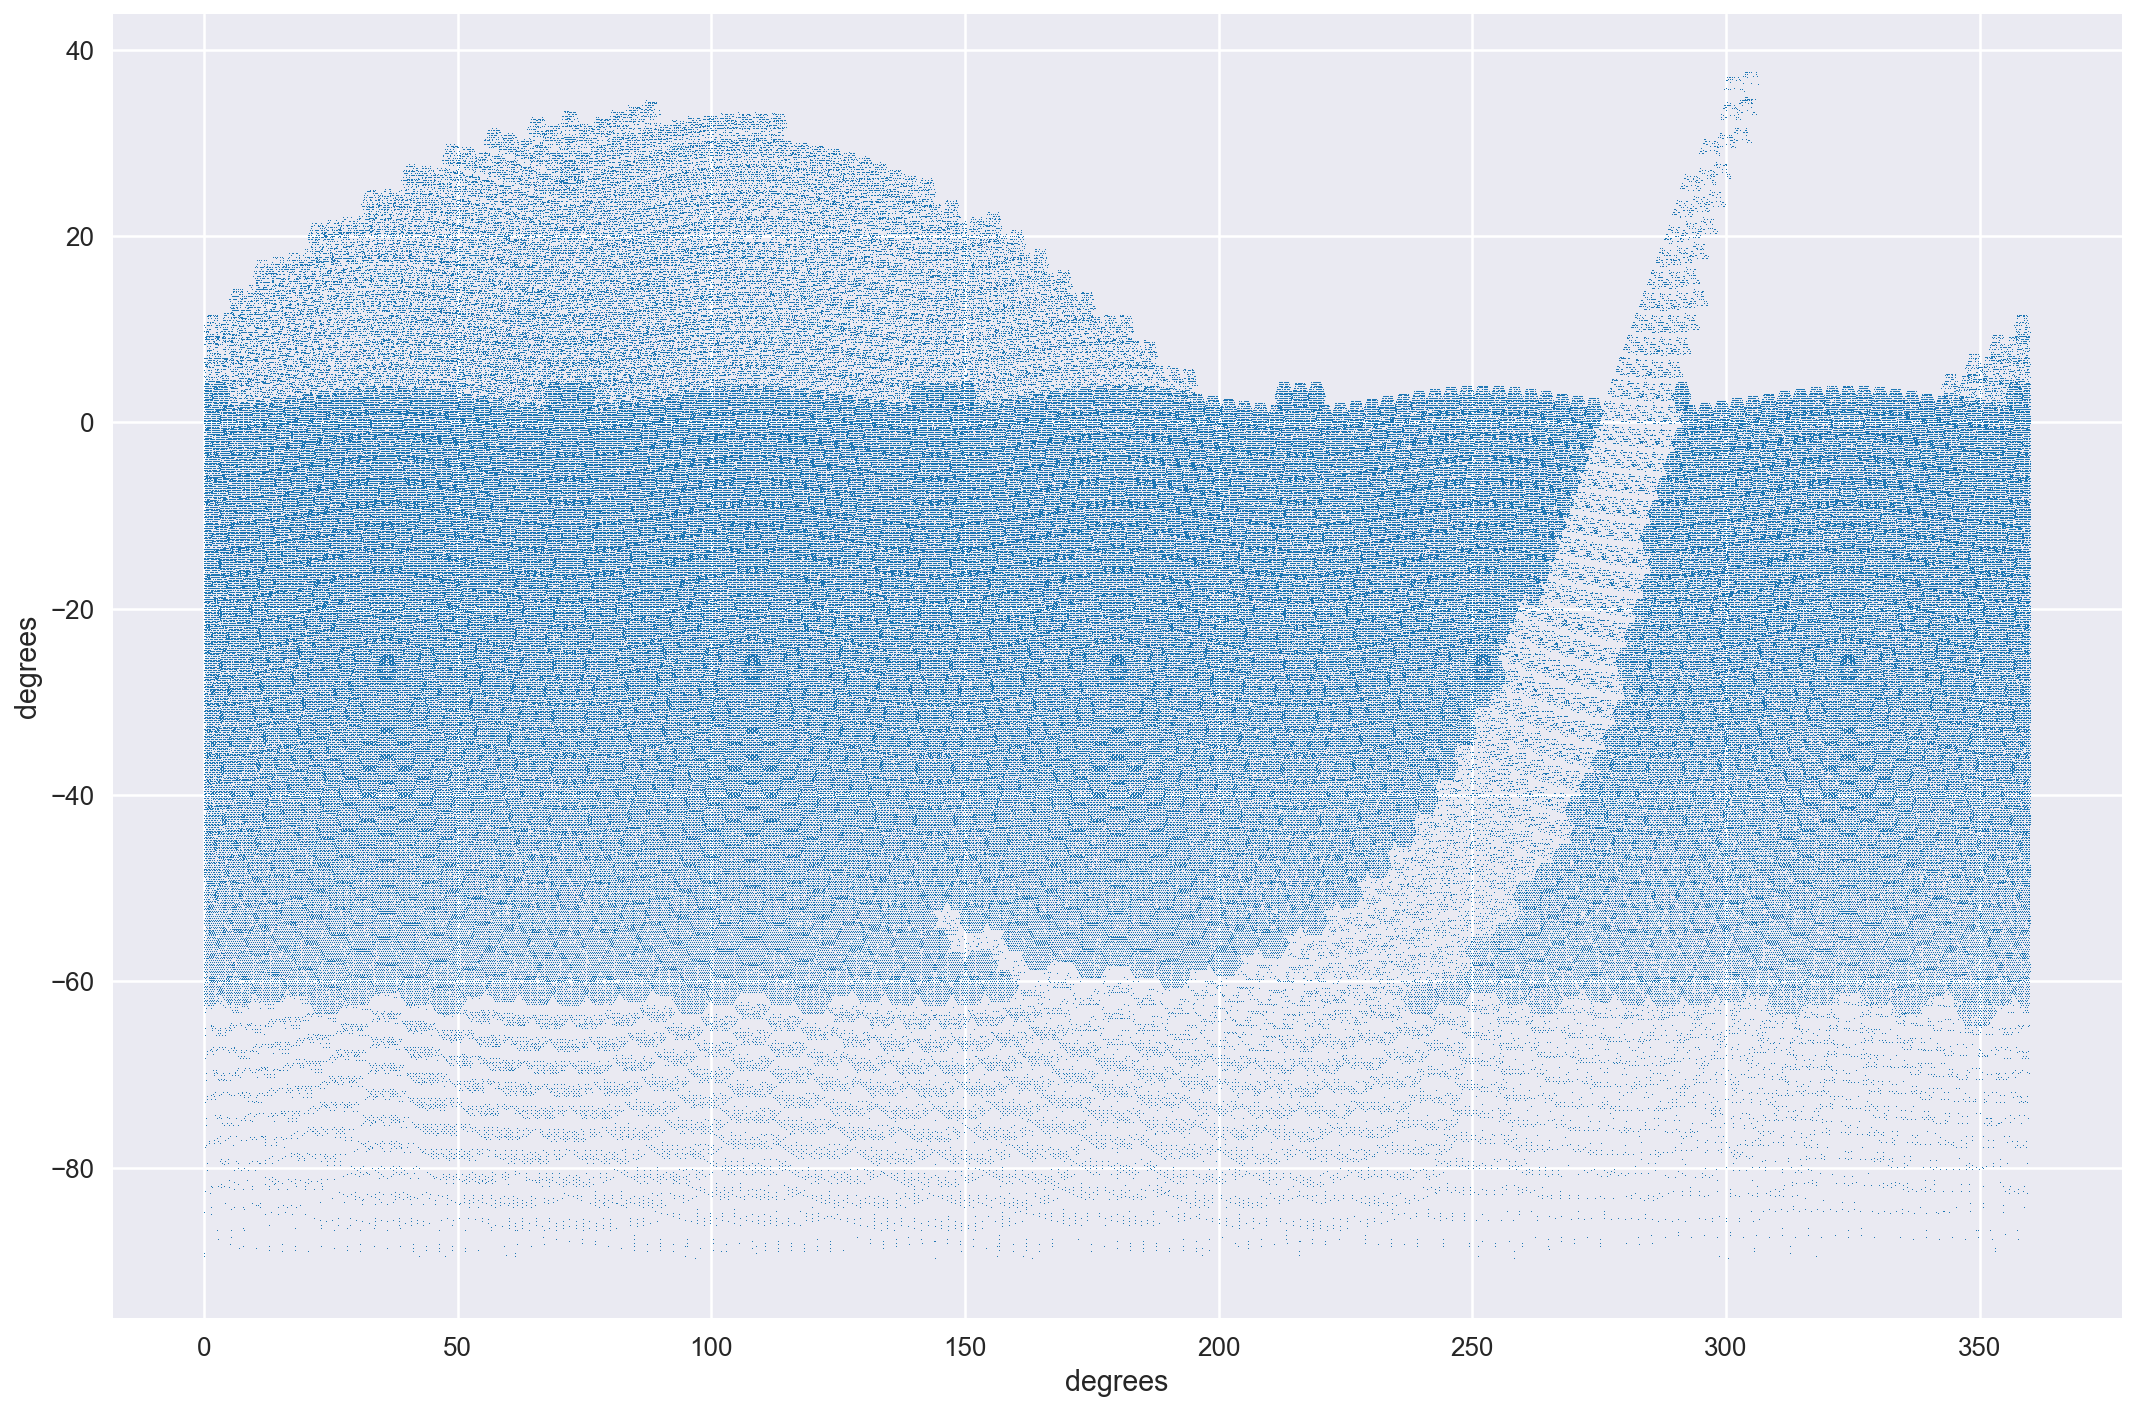

In [44]:
pos2,pos3 = np.array(pos2),np.array(pos3)
plt.plot(pos2*180/np.pi,pos3*180/np.pi,',')
plt.xlabel('degrees')
plt.ylabel('degrees')
plt.savefig('fullsky.png')

In [45]:
!open .

In [51]:
np.radians(-40)

-0.69813170079773179

In [29]:
hp.gnomview??

In [34]:
resultsDb.getSummaryStats()

array([ (2, 'Count expMJD', 'HealpixSlicer', ' r and night < 400 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0', 'Sum',  212719.),
       (2, 'Count expMJD', 'HealpixSlicer', ' r and night < 400 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0', 'Sum',  212674.)],
      dtype=[('metricId', '<i8'), ('metricName', 'S1024'), ('slicerName', 'S1024'), ('metricMetadata', 'S1024'), ('summaryName', 'S1024'), ('summaryValue', '<f8')])

### Comments
- It might be worth having a separate item on making sure the code for both parts is clearly documented, reproducible, and extendable - so that as new PSF modelling software is developed or new survey strategies are considered, we can later come back to this as a group without reinventing the wheel.
- It seems that the parts of OpSim/MAF that we need are surprisingly well-documented and there are notebooks with examples of the kinds of things we need (e.g., generate a survey and then for a given point, find all exposures that contribute to it and where is that point in the focal plane) https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/Dithers.ipynb
- Part 2.1B 2. (When part one has results) Take the mean PSF error from part one. Generate dither patterns using OpSim or find existing ones. [R] I started talking with Humna, who already sent us some info; turns out it’s quite straightforward for us to get ALL the dither patterns explored in her work. For this reason I’m not sure (4) needs to be a stretch goal, as we can do anything available in Opsim/MAF with a similar level of ease.

### Jargon:
- [OpSim](https://github.com/lsst/sims_operations) LSST Operation Simulator — simulates 10-year surveys, accounting for realistic factors that affect the final data; these considerations include scheduling of observations, telescope pointing, slewing and downtime, site condition, etc. OpSim output contains realisations of LSST metadata, stamped with sky position, time, and filter, allowing post-processing of the output to simulate different dither strategies.
- [MAF](https://github.com/lsst/sims_maf) Metrics Analysis Framework, designed for the analysis of OpSim output in a manner that facilitates hierarchical building of the analysis tools. MAF consists of various classes, of which most relevant here are Metrics that contain algorithm to analyse each [HEALPix](https://healpix.sourceforge.net/documentation.php) pixels, and Stackers, that provide the functionality of adding columns to the OpSim database.
- [ImSim](https://github.com/LSSTDESC/imSim) GalSim based LSST simulation package
- [SSim](https://github.com/LSSTDESC/SSim_DC1) Configuration, production, validation and tools for the DC1 Data Set
- [Piff](https://rmjarvis.github.io/Piff/html/index.html) is a Python software package for modeling the point-spread function (PSF) across multiple detectors in the full field of view (FOV).
- [PSFEx](https://psfex.readthedocs.io/en/latest/) PSF Extractor is a computer program that extracts precise models of the Point Spread Functions (PSFs) from images processed by SExtractor and measures the quality of images. The generated PSF models can be used for model-fitting photometry or morphological analyses.
- [PhoSim](https://www.lsst.org/scientists/simulations/phosim) The Photon Simulator is a set of fast photon Monte Carlo codes used to calculate the physics of the atmosphere and a telescope and camera in order to simulate realistic astronomical images. It does this using modern numerical techniques applied to comprehensive physical models. PhoSim generates images by collecting photons into pixels. This movie shows the photon Monte Carlo method used in the simulation. 



In [11]:
%pylab inline
from angles import r2d, r2arcs, d2arcs
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr, healpy as hp
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 18,12
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from collections import defaultdict
from scipy.stats import moment

class ModelErrors():
    
    def __init__(self,ModelType,WorstCase):
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.alpha = None 
        self.ModelType = ModelType
        self.survey_area = (np.radians(200),np.radians(50)) # in radians
        stars_X = np.random.rand(int(1E4))*self.survey_area[0] 
        stars_Y = np.random.rand(int(1E4))*self.survey_area[1] - self.survey_area[1]
        stars = np.array((stars_X,stars_Y))
        self.stars = stars.swapaxes(1,0)
        self.e = defaultdict(list)
        self.worst_case = WorstCase
        
    def PSF(self):
        pass
    
    def STAR(self):
        pass

    def getModels(self):
        '''calls one of the model methods to create an overly simplified model, 
        or (N/A yet) imports one'''
        # construct a circle around the central position.
#         if self.ModelType == 'radial':
#             map(lambda x: self.radial_pattern(position_num=x),([(lambda x: x*x)(x) for x in range(10)]))
        for i in range(len(self.positions)):
            if self.ModelType == 'radial':
                if self.worst_case==True:
                    self.worst_case_radial(position_num=i)
                else:
                    self.radial_pattern(position_num=i)
            # elif self.ModelType == 'horizontal':
            #         self.de1[i], self.de2[i] = horizontal_pattern(position)
    
    def getPositions(self,sqlWhere,database='/Users/myhome/Downloads/minion_1016_sqlite.db'):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere'''
        opsdb = db.OpsimDatabase(database)
        pos = opsdb.fetchMetricData(('ditheredRA', 'ditheredDec'), sqlconstraint=sqlWhere)
        pos = np.array(pos)
        if any(row[1] == x for row in pos):
            pos2 = zip(*pos)[1]
        if any(row[2] == x for row in pos):
            pos3 = zip(*pos)[2]
        pos = np.array((pos2,pos3))
        self.positions = pos.swapaxes(1,0)
        
    def avgOver(self):
        ''' should rewrite '''
        for pos in self.e.keys(): self.M[pos] = (np.mean(self.M[i][0]),np.mean(self.M[i][1]))
        Mxx,Mxy,Myy = self.M
        self.de1 = (Mxx-Myy)/TrM
        self.de2 = 2*Mxy/TrM
        self.sigma = np.sqrt(TrM/2)
    def process(self,sqlWhere):
        ''' runs all analysis methods '''
        self.getPositions(sqlWhere)
        self.getModels()
        self.avgOver()
        self.getTraces()
        self.getRhos()
        self.rhos2errors()
        
        
    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.'''
        de1 = np.zeros(len(self.e.keys()))
        de2 = np.zeros(len(self.e.keys()))
        for j,i in enumerate(self.e.keys()):
            de1[j] = self.e[i][0][0]
            de2[j] = self.e[i][0][1]
        de = np.sqrt(e1**2 + e2**2)
        cat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
        gg = treecorr.GGCorrelation(min_sep=0.01, max_sep=50, nbins=100, sep_units='degrees')
        gg.process(cat)
        xip = gg.xip
        xim = gg.xim
        sigma = gg.varxi**0.5
        self.r = np.exp(dede.meanlogr)
        self.rho1 = dede.xi
        
        self.rho2 = None
        self.rho3 = None
        self.rho4 = None
        self.rho5 = None
        
    def getTraces(self):
        '''gets traces from sizes etc to be used in getting rho statistics'''
        self.T_PSF = None
        self.T_gal = None # this could be moved to init, but keeping it here for consistency 
    
    def rhos2errors(self):
        '''propagates rho statistics into shear errors'''
        self.delta_xip = 2 * (self.delta_T_psf / self.T_gal) * self.xip \
                    + (self.T_PSF/self.T_gal)**2 * rho1                 \
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho2  \
                    + (self.T_PSF/self.T_gal)**2 * self.rho3            \
                    + (self.T_PSF/self.T_gal)**2 * self.rho4            \
                    - self.alpha * (self.T_PSF/self.T_gal) * self.rho5
                    
    def radial_pattern(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin'''
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        try:
            rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        except: 
            return
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        de1 = r*np.cos(2*theta)/20
        de2 = r*np.sin(2*theta)/20
        Mxx = 0.5*TrM*(de1+1)
        Mxy = 0.5*TrM*de2
        Myy = 0.5*TrM*(-de1+1)
        for i in range(len(e1)):
            self.e[(stars[i][0],stars[i][1])] += (Mxx[i],Mxy[i],Myy[i])
    
    def worst_case_radial(self,position_num):
        from angles import r2d, r2arcs, d2arcs
        center = self.positions[position_num]
        stars = self.stars[np.where(((self.stars[:,0]-center[0])**2+(self.stars[:,1]-center[1])**2)<np.radians(1.2))[0]] 
        try:
            rel_X, rel_Y = stars[:,0] - center[0], stars[:,1] - center[1]
        except: 
            return
        r = np.sqrt(rel_X**2+rel_Y**2)
        theta = np.arctan((rel_Y)/(rel_X))
        de1 = r*np.cos(2*theta)/20
        de2 = r*np.sin(2*theta)/20
        for i in range(len(e1)):
            if (stars[i][0],stars[i][1]) in self.e.keys():
                pass
            else:
                self.e[(stars[i][0],stars[i][1])].append((de1[i],de2[i]))
    def horizontal_pattern(self): ## untested for new algorithm
        ''' method to create a horizontal pattern (one of the overly simplified models) 
            e = 0.1'''
        from angles import r2d, r2arcs, d2arcs
        e1 = np.ones(1000)*0.1
        e2 = np.zeros(len(self.stars_X))
        return e1,e2
    
    # I should probably combine both patterns into a single method. 


Populating the interactive namespace from numpy and matplotlib


In [12]:
best_case = ModelErrors('radial',WorstCase=False)

In [13]:
best_case.worst_case

False

In [15]:
best_case.getPositions(sqlWhere='filter = "r" and night < 40000 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

In [16]:
best_case.getModels()

In [18]:
best_case.avgOver()

KeyboardInterrupt: 

In [20]:
for i in best_case.e.keys(): best_case.e[i] = (np.mean(best_case.e[i][0]),np.mean(best_case.e[i][1]))

In [98]:
inst.e[(1.4068431858253827, -0.63396712113576004)][0][1]

0.0032838800224622077

In [21]:
best_case.getRhos()

IndexError: invalid index to scalar variable.

In [26]:
e1 = np.zeros(len(best_case.e.keys()))
e2 = np.zeros(len(best_case.e.keys()))
for j,i in enumerate(best_case.e.keys()):
    e1[j] = best_case.e[i][0]
    e2[j] = best_case.e[i][1]
de = np.sqrt(e1**2 + e2**2)
cat = tr.Catalog(g1=e1,g2=e2, ra=np.array(best_case.e.keys())[:,0], dec=np.array(best_case.e.keys())[:,1],ra_units='radians',dec_units='radians')
dede = tr.GGCorrelation(min_sep=0.01, max_sep=50, nbins=100, sep_units='degrees')
dede.process(cat)
best_case.r  = np.exp(dede.meanlogr)
best_case.rho1 = dede.xip

best_case.rho2 = None
best_case.rho3 = None
best_case.rho4 = None
best_case.rho5 = None

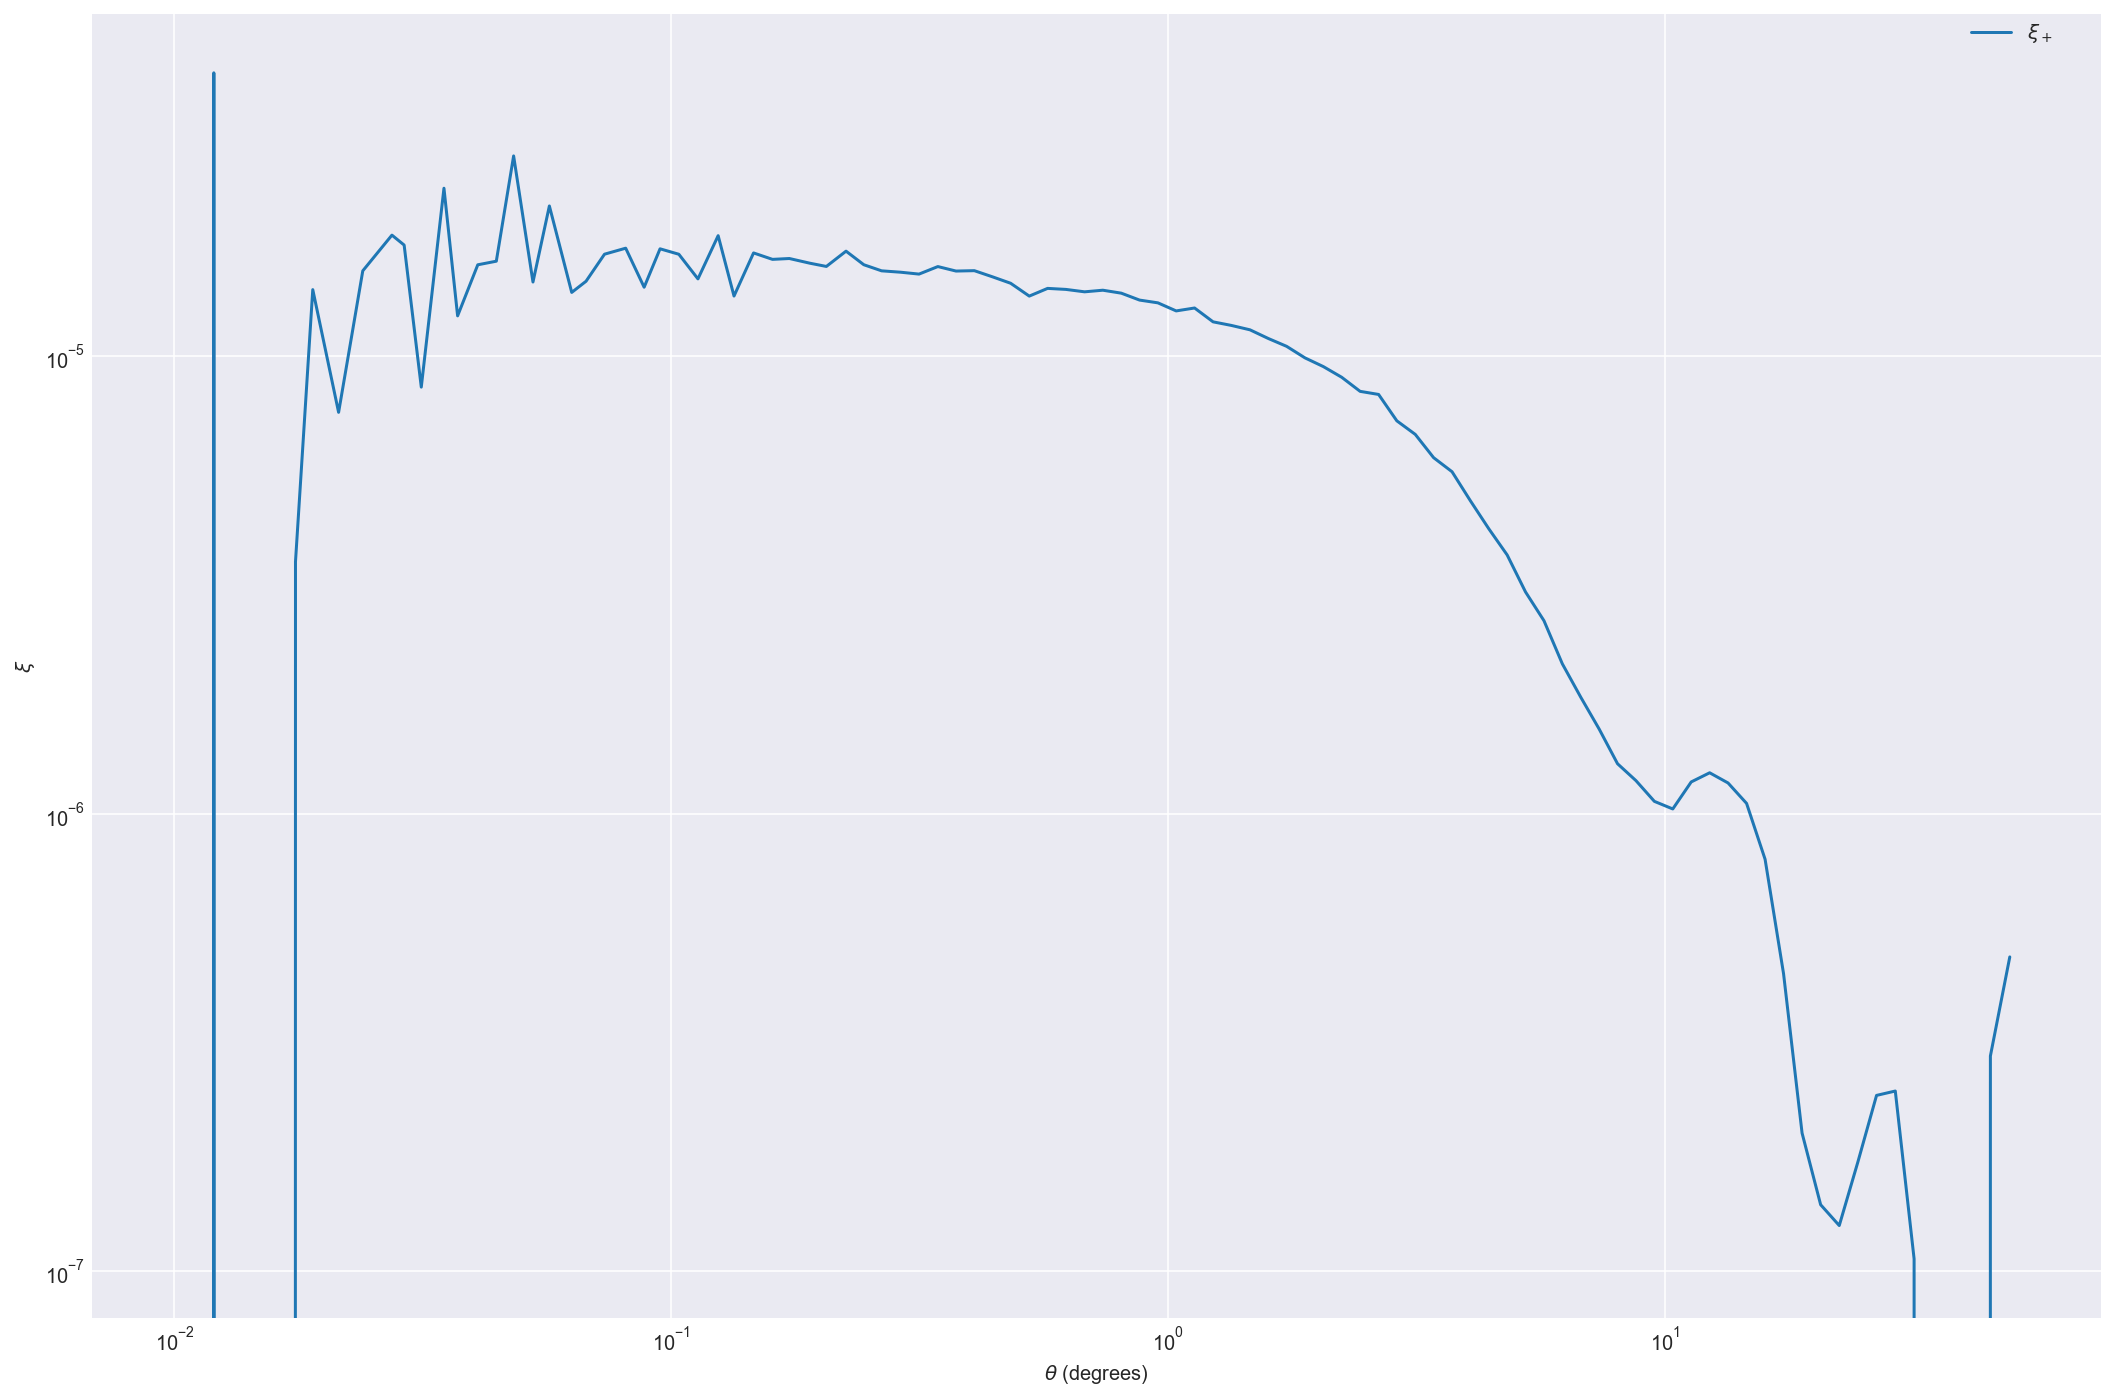

In [27]:
plt.plot(best_case.r,best_case.rho1)
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [111]:
print np.mean(e2), np.std(e2)/np.sqrt(len(e2))

-4.36768411663e-05 3.54360697043e-05


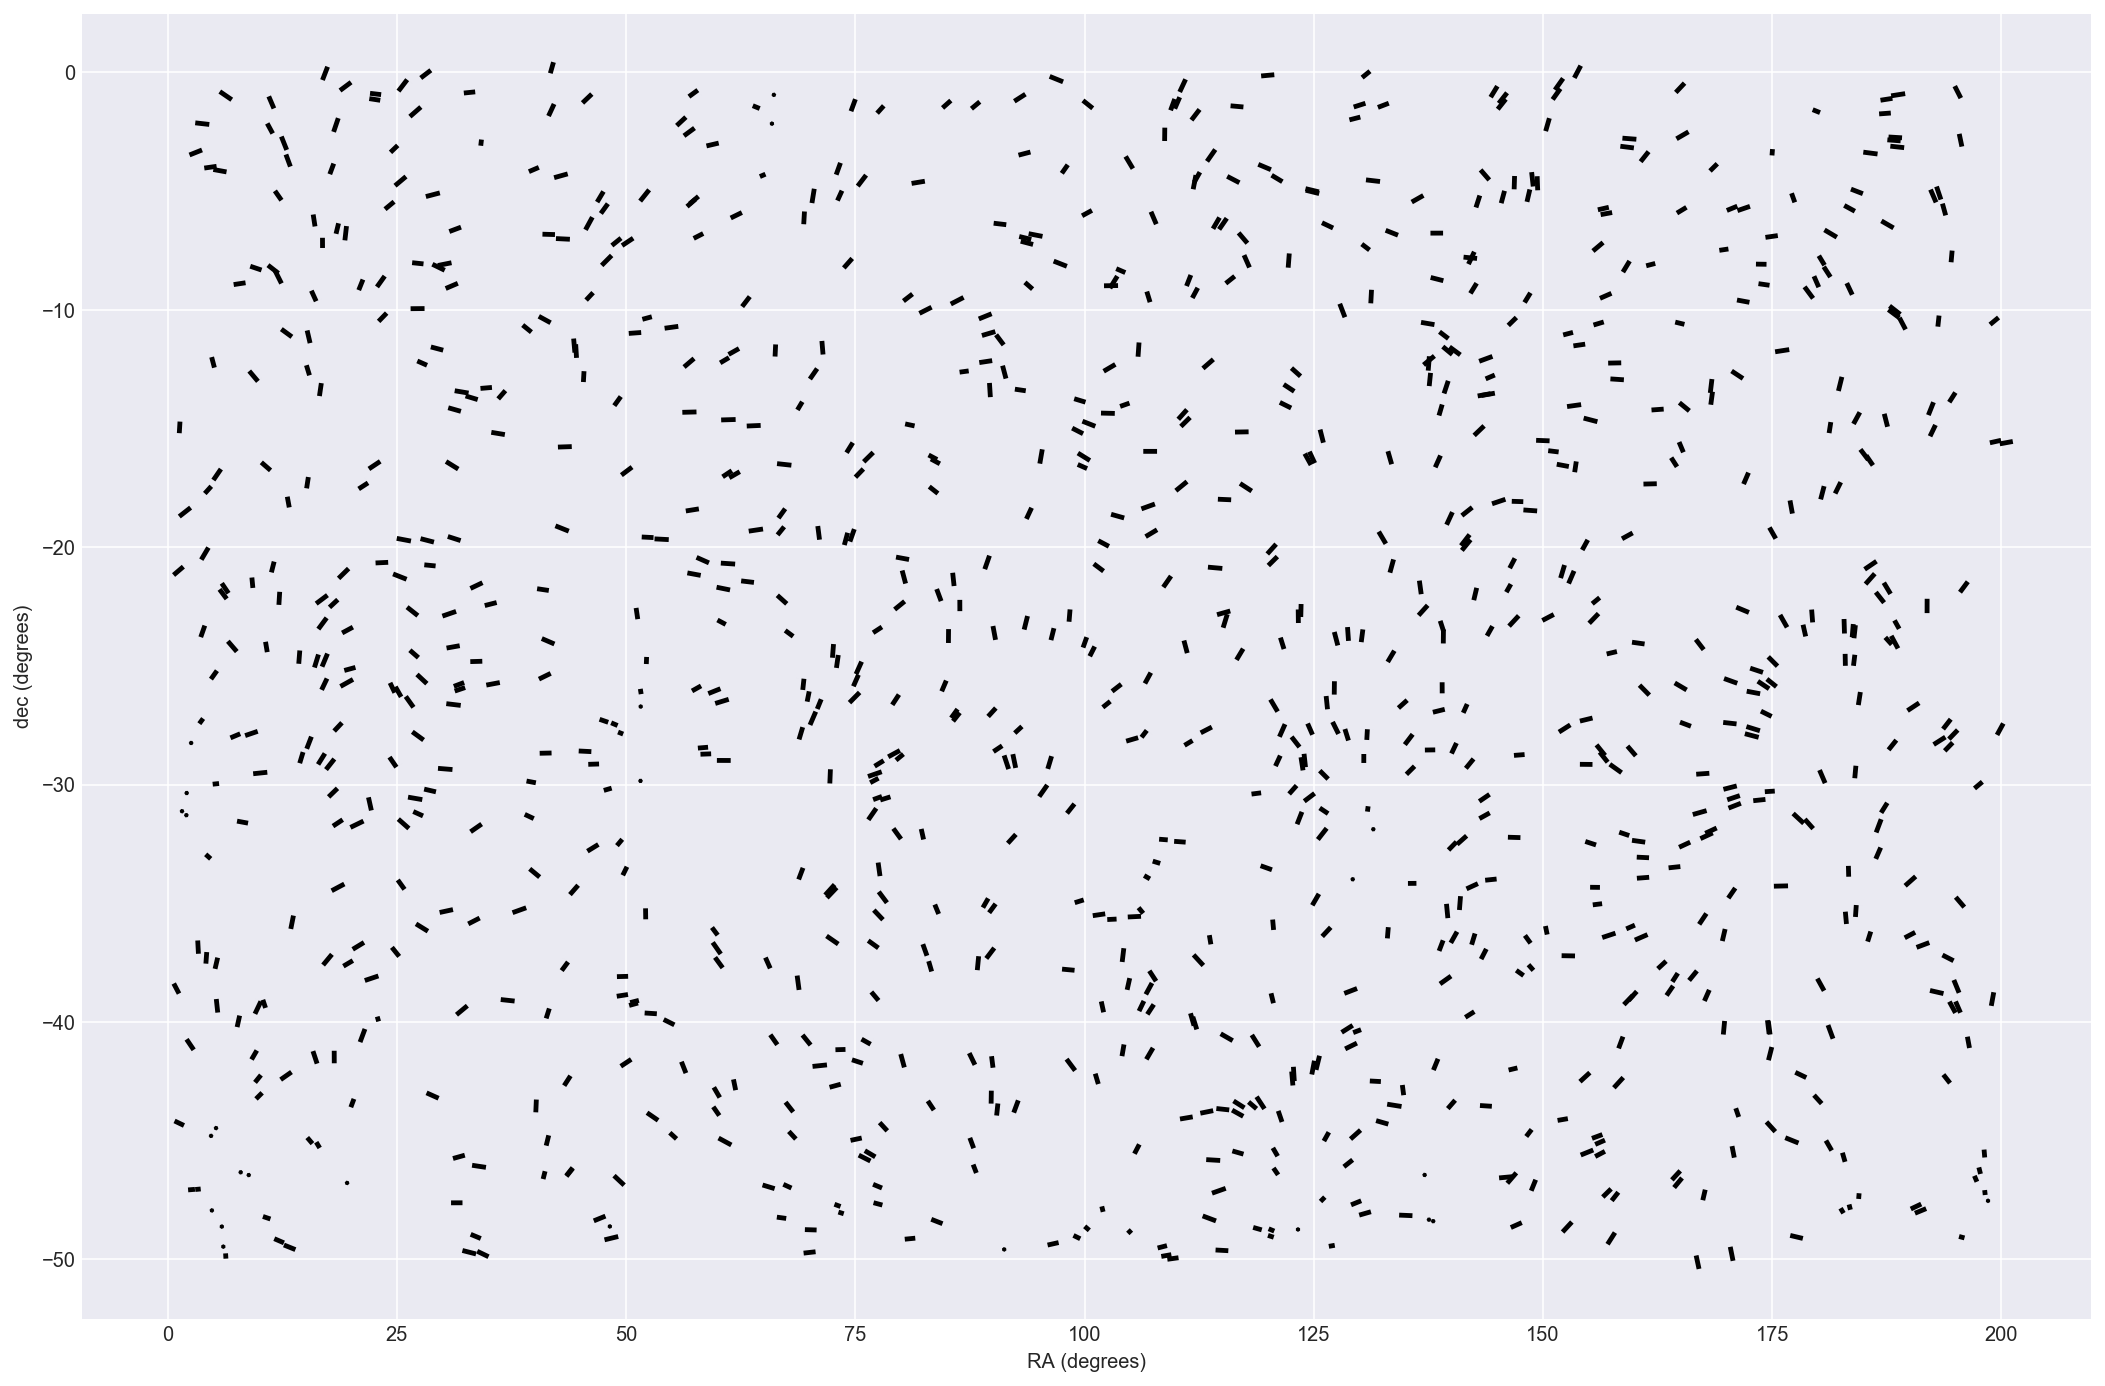

In [33]:
X = np.array(inst.e.keys())[:,0]
Y = np.array(inst.e.keys())[:,1]
e1 = np.array(inst.e.values())[:,0][:,0]
e2 = np.array(inst.e.values())[:,0][:,1]
angles = np.zeros(len(X))
U = np.sqrt(e1**2+e2**2)
for i in range(len(U)):
    angles[i] = r2d(0.5*np.arctan2(e2[i],e1[i]))
pixel_scale = r2d(1)
V = np.zeros(np.shape(U))
Q = plt.quiver(pixel_scale*X,Y*pixel_scale,U,V,angles=angles,
               headlength=0,headaxislength=0,scale=1,cmap='viridis')
plt.xlabel('RA (degrees)')
plt.ylabel('dec (degrees)')
#qk = plt.quiverkey(Q, 0.8, 0.85, 0.05, r'$|e|=0.05$', labelpos='E', coordinates='figure')

/usr/local/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


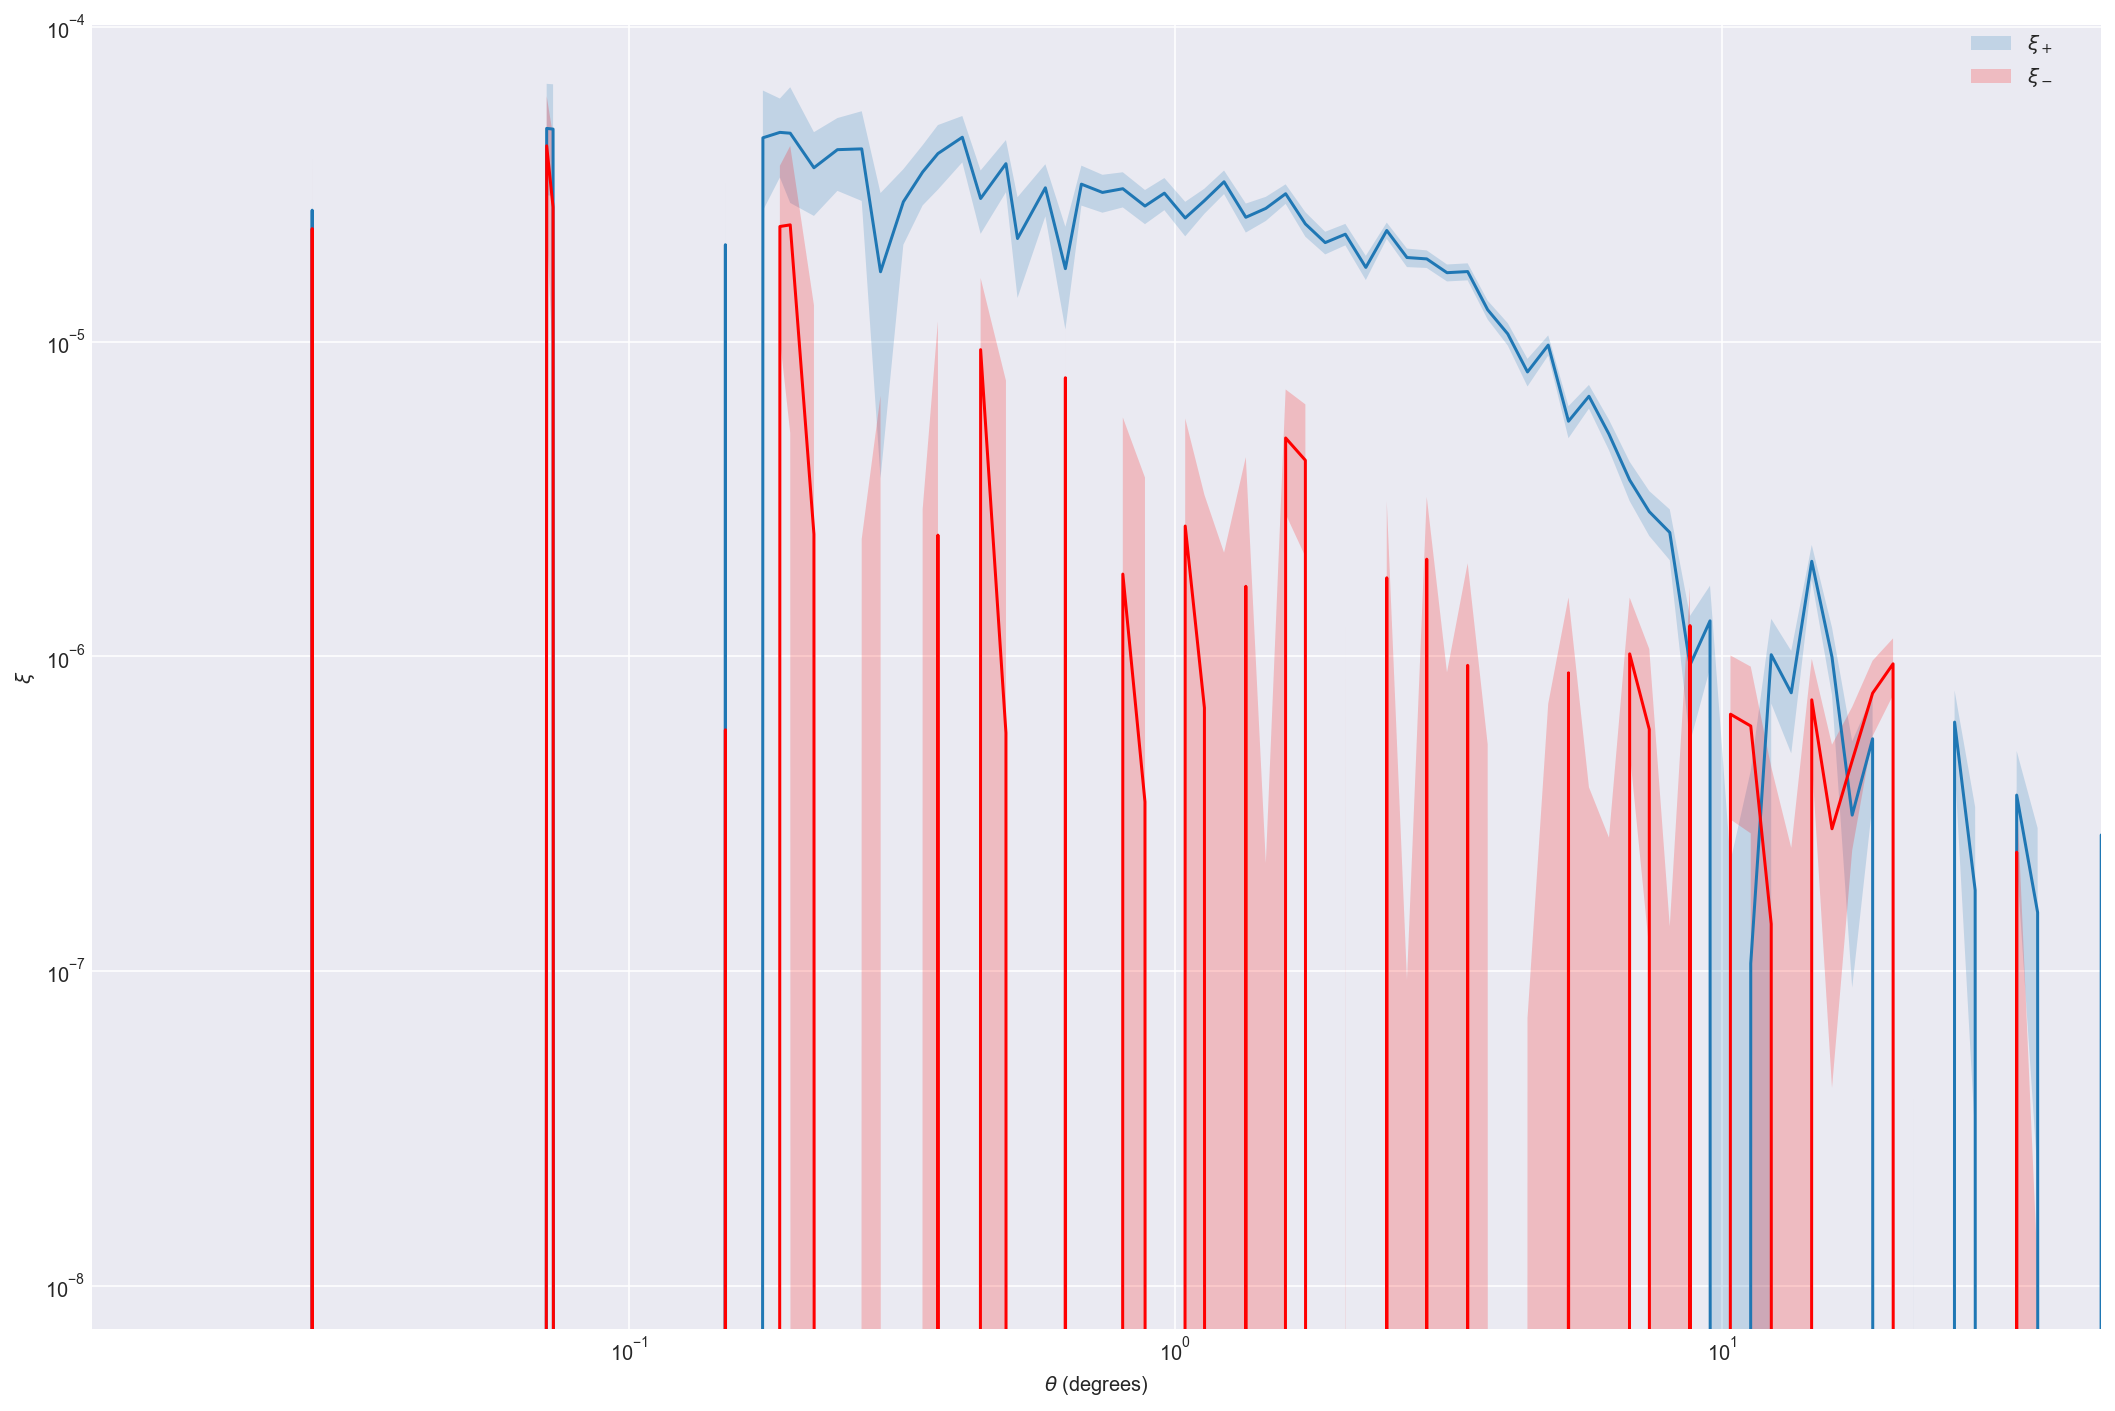

In [34]:
import treecorr
cat = treecorr.Catalog(g1=e1, g2=e2, ra=X, dec=Y,ra_units='radians',dec_units='radians')
gg = treecorr.GGCorrelation(min_sep=0.01, max_sep=50, nbins=100, sep_units='degrees')
gg.process(cat)
xip = gg.xip
xim = gg.xim
sigma = gg.varxi**0.5
import seaborn.timeseries

def _plot_std_bars(std=None, central_data=None, ci=None, data=None,*args, **kwargs):
    std = sigma
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)
seaborn.timeseries._plot_std_bars = _plot_std_bars
r = np.exp(gg.meanlogr)
sns.tsplot(xip,r,err_style='std_bars')
sns.tsplot(xim,r,err_style='std_bars',color='r')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel(r'$\xi$')
plt.xscale('log')
plt.yscale('log')
plt.legend([r'$\xi_+$',r'$\xi_-$'],bbox_to_anchor=(0.98, 1), loc='upper right', borderaxespad=0.)

In [2]:
import numpy as np
0.7/(2*np.sqrt(2*np.log(2)))

0.29726263010080667